# Distance Analysis: codex-intestine-stanford

> Analyze and visualize cell-to-nearest-endothelial-cell distance distributions for the `codex-intestine-stanford` dataset.

In [ ]:
import numpy as np
import pandas as pd
import os
import json
import requests
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
import plotly.express as px

from _cde_compute_edges_from_nodes import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# suppress warnings
import warnings
warnings.filterwarnings("ignore")   

In [2]:
basepath = "/u/yashjain/hra-cell-distance-analysis/data"
dataset_dir = "intestine-codex-stanford"
data_filedir = os.path.join("data-processed-nodes-with-harmonized-cell-types", dataset_dir)
output_edge_dir = os.path.join("data-processed-edges", dataset_dir)
figures_output_dir = "generated-figures"

In [3]:
# Function to load your data
def load_data(path, edges=False):
    if edges:
        column_names = ['cell_id', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2']
        data = pd.read_csv(path, header=None, names=column_names)
    else:
        data = pd.read_csv(path)
    return data

In [4]:
# Function to read all files ending with "-nodes.csv" in the `data_filedir` directory into a single DataFrame. 
# Another additional column `Dataset` is added to identify the dataset name which comes from the filename before the `-nodes.csv` suffix.

# Additionally, function reads all files ending with "-edges.csv" in the `output_edge_dir` directory into a single DataFrame. 
# Three additional columns are added "Dataset", "Anchor Cell Type", and "Anchor Cell Type Level" to identify the dataset name, anchor cell type, and anchor cell type level respectively which come from the filename before the `.csv` suffix.
# The three additional columns are created by splitting the filename on the `-` character, and extracting the relevant parts.
# On splitting, the first part is the dataset name, second part is the anchor cell type level, and third part is the anchor cell type, and last part is the `edges` suffix.
# When reading files, check if the file has the correct format (i.e., ends with `-edges.csv`).

# Additionally, the function merges the edges DataFrame with the nodes DataFrame to get the cell type information for the anchor cells.
# This is done by reading the corresponding nodes file from the `data_filedir` directory for each edges file, and merging it with the edges DataFrame on the `cell_id` column.
# The merged DataFrame contains the edges with additional columns for the cell type information.

# The function returns three DataFrames:
# 1. `merged_nodes`: DataFrame containing all nodes with an additional column `Dataset`.
# 2. `merged_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, and `Anchor Cell Type Level`.
# 3. `merged_nodes_for_all_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, `Anchor Cell Type Level`, and the cell type information for cells.
def read_all_edge_datasets(basepath, data_filedir, output_edge_dir):
    all_nodes_files = []
    all_edges_files = []
    all_nodes_edges_files = []
    for file in os.listdir(os.path.join(basepath, output_edge_dir)):
        if file.endswith("-edges.csv"):
            file_path = os.path.join(basepath, output_edge_dir, file)
            dataset_name, anchor_cell_type_level, anchor_cell_type = file.replace("-edges.csv", "").split('-')
            edges_df = load_data(file_path, edges=False)
            edges_df['Dataset'] = dataset_name
            edges_df['Anchor Cell Type'] = anchor_cell_type
            edges_df['Anchor Cell Type Level'] = anchor_cell_type_level
            edges_df.rename(columns={"distance": "Distance"}, inplace=True) # Rename column "distance" to "Distance".
            all_edges_files.append(edges_df)

            # Read the corresponding nodes file from data_filedir to get the cell type information
            nodes_file_path = os.path.join(basepath, data_filedir, f"{dataset_name}-nodes.csv")
            nodes_df = load_data(nodes_file_path)
            nodes_df['Dataset'] = dataset_name
            all_nodes_files.append(nodes_df)

            # Add a new 'cell_id' column to nodes_df
            nodes_df['cell_id'] = range(len(nodes_df))
            # Set 'cell_id' column as index for nodes_df
            nodes_df.set_index('cell_id', inplace=True)
            # Merge edges_df with nodes_df to get the cell type information for the anchor cells
            edges_nodes_df = pd.merge(edges_df, nodes_df[['Level Three Cell Type', 'Level Two Cell Type', 'Level One Cell Type']], how='left', left_on='cell_id', right_index=True)
            all_nodes_edges_files.append(edges_nodes_df)

    
    merged_edges = pd.concat(all_edges_files, ignore_index=True)
    merged_nodes = pd.concat(all_nodes_files, ignore_index=True)
    merged_nodes_for_all_edges = pd.concat(all_nodes_edges_files, ignore_index=True) 

    return merged_nodes, merged_edges, merged_nodes_for_all_edges

In [5]:
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")

## Get initial statistics and identify endothelial cell categories for dataset.

In [6]:
df_all_nodes, df_all_edges, df_all_edges_with_cell_types = read_all_edge_datasets(basepath, data_filedir, output_edge_dir)

In [7]:
df_all_nodes.head(5)

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset
0,1503.64128,1278.32154,NK,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,B004_Ascending
1,1958.05496,1553.46072,NK,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,B004_Ascending
2,2290.93940,1187.36332,NK,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,B004_Ascending
3,2863.48554,891.08862,NK,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,B004_Ascending
4,2563.43664,1468.54122,NK,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,B004_Ascending


In [8]:
# Print the total number of unique cell types per dataset. Compute separately for each cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type).
print("Total number of unique cell types per cell type annnotation level:")
unique_cell_types = {
    'Original Cell Type': df_all_nodes['Original Cell Type'].nunique(),
    'Level Three Cell Type': df_all_nodes['Level Three Cell Type'].nunique(),
    'Level Two Cell Type': df_all_nodes['Level Two Cell Type'].nunique(),
    'Level One Cell Type': df_all_nodes['Level One Cell Type'].nunique()
}
for cell_type, count in unique_cell_types.items():
    print(f"{cell_type}: {count}")

Total number of unique cell types per cell type annnotation level:
Original Cell Type: 25
Level Three Cell Type: 25
Level Two Cell Type: 17
Level One Cell Type: 5


In [9]:
# Save the unique cell types containing "endothelial" in name per cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type) to a dictionary where the key is the level and the value is a list of unique cell types.
endothelial_cell_types = {
    'Original Cell Type': df_all_nodes[df_all_nodes['Original Cell Type'].str.contains("endothelial", case=False, na=False)]['Original Cell Type'].unique().tolist(),
    'Level Three Cell Type': df_all_nodes[df_all_nodes['Level Three Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Three Cell Type'].unique().tolist(),
    'Level Two Cell Type': df_all_nodes[df_all_nodes['Level Two Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Two Cell Type'].unique().tolist(),
    'Level One Cell Type': df_all_nodes[df_all_nodes['Level One Cell Type'].str.contains("endothelial", case=False, na=False)]['Level One Cell Type'].unique().tolist()
}

print("\nEndothelial cell types per cell type annotation level:")
for level, cell_types in endothelial_cell_types.items():
    print(f"\n{level}:")
    for cell in cell_types:
        print(f"  - {cell}")


Endothelial cell types per cell type annotation level:

Original Cell Type:
  - Endothelial

Level Three Cell Type:
  - endothelial cell of lymphatic vessel
  - endothelial cell

Level Two Cell Type:
  - endothelial cell of lymphatic vessel
  - endothelial cell

Level One Cell Type:
  - endothelial cell


In [10]:
type_field_list = ["Level Three Cell Type", "Level Two Cell Type", "Level One Cell Type"] # Skipping Original Cell Type as it is not a hierarchical level.

# Define the anchor cell type (type of endothelial cell) for each level in type_field_list based on available categories in the previous cell. The distance analysis at all three levels will be limited to the specified anchor cell type.
anchor_cell_type_dict = {
    'Level Three Cell Type': 'endothelial cell',
    'Level Two Cell Type': 'endothelial cell',
    'Level One Cell Type': 'endothelial cell'
}

## Process datasets to add region information to Nodes files.

In [11]:
# List of regions (based on filenames) in small intestine (si) and large intestine (li).
si = ['Duodenum', 'Ileum', 'Mid', 'ProximalJejunum', 'Midjejunum', 'Proximaljejunum']
li = ['Ascending', 'Descending', 'Transverse', 'Left', 'Right', 'Sigmoid', 'Trans']

# Create a dictionary to map si and li regions to correct region names.
region_map = {
    'Duodenum': 'Duodenum',
    'Ileum': 'Ileum',
    'Mid': 'Mid Jejunum',
    'ProximalJejunum': 'Proximal Jejunum',
    'Midjejunum': 'Mid Jejunum',
    'Proximaljejunum': 'Proximal Jejunum',
    'Ascending': 'Ascending',
    'Descending': 'Descending',
    'Transverse': 'Transverse',
    'Left': 'Descending',
    'Right': 'Ascending',
    'Sigmoid': 'Sigmoid',
    'Trans': 'Transverse'
}

In [12]:
df_all_nodes.head()

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset
0,1503.64128,1278.32154,NK,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,B004_Ascending
1,1958.05496,1553.46072,NK,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,B004_Ascending
2,2290.93940,1187.36332,NK,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,B004_Ascending
3,2863.48554,891.08862,NK,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,B004_Ascending
4,2563.43664,1468.54122,NK,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,B004_Ascending


In [13]:
# Iterate through the df_all_data dataframe to create new columns "Donor" and "Unique Region" based on the "Dataset" column.
# The "Donor" column is created by extracting the donor name from the "Dataset" column, for example B004 from B004_Duodenum.
# The "Unique Region" column is created by mapping the region names based on the full dataset name.
df_all_nodes['Donor'] = df_all_nodes['Dataset'].str.split('_').str[0]
df_all_nodes['Unique Region'] = df_all_nodes['Dataset'].str.split('_').str[1].map(region_map)

# Check if the new columns are created correctly.
df_all_nodes[['Dataset', 'Donor', 'Unique Region']].head(5)

,Dataset,Donor,Unique Region
0,B004_Ascending,B004,Ascending
1,B004_Ascending,B004,Ascending
2,B004_Ascending,B004,Ascending
3,B004_Ascending,B004,Ascending
4,B004_Ascending,B004,Ascending


In [14]:
# Iterate through the df_all_data dataframe to create a new column "Tissue Subtype" based on Dataset column value after "_".
df_all_nodes['Tissue Subtype'] = df_all_nodes['Dataset'].str.split('_').str[1].apply(lambda x: 'Small Intestine' if x in si else ('Large Intestine' if x in li else 'Unknown'))

In [15]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_nodes['Unique Region'].unique())

# Print all unique donors in the data.
print("\nUnique Donors in the data:")
print(df_all_nodes['Donor'].unique())

# Print unique values in Tissue Subtype.
print("\nUnique Tissue Subtypes in the data:")
print(df_all_nodes['Tissue Subtype'].unique())

# Print number of donors in small intestine and large intestine.
print("\nNumber of donors in Small Intestine:")
print(df_all_nodes[df_all_nodes['Tissue Subtype'] == 'Small Intestine']['Donor'].nunique())
print("\nNumber of donors in Large Intestine:")
print(df_all_nodes[df_all_nodes['Tissue Subtype'] == 'Large Intestine']['Donor'].nunique())

# Print the total number of unique donors and unique regions.
print(f"\nTotal number of unique donors: {df_all_nodes['Donor'].nunique()}")
print(f"\nTotal number of unique donors: {df_all_nodes['Donor'].nunique()}")
print(f"Total number of unique regions: {df_all_nodes['Unique Region'].nunique()}")

# Print number of unique datasets per small intestine and large intestine.
print(f"\nTotal number of unique datasets in Small Intestine: {df_all_nodes[df_all_nodes['Tissue Subtype'] == 'Small Intestine']['Dataset'].nunique()}")
print(f"Total number of unique datasets in Large Intestine: {df_all_nodes[df_all_nodes['Tissue Subtype'] == 'Large Intestine']['Dataset'].nunique()}")


Unique Regions in the data:
['Ascending' 'Descending' 'Duodenum' 'Ileum' 'Mid Jejunum'
 'Proximal Jejunum' 'Transverse' 'Sigmoid']

Unique Donors in the data:
['B004' 'B005' 'B006' 'B009' 'B010' 'B011' 'B012' 'B008']

Unique Tissue Subtypes in the data:
['Large Intestine' 'Small Intestine']

Number of donors in Small Intestine:
8

Number of donors in Large Intestine:
8

Total number of unique donors: 8

Total number of unique donors: 8
Total number of unique regions: 8

Total number of unique datasets in Small Intestine: 32
Total number of unique datasets in Large Intestine: 32


## Process datasets to add region information to Edges files.

In [16]:
df_all_edges.head(5)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level
0,0,1503.64128,1278.32154,0,1541.00586,1229.63436,0,61.372252,B004_Ascending,endothelial cell of lymphatic vessel,Level Three Cell Type
1,726,1428.15728,1210.38594,0,1404.75724,1149.62132,0,65.114522,B004_Ascending,endothelial cell of lymphatic vessel,Level Three Cell Type
2,727,1428.15728,1216.80208,0,1404.75724,1149.62132,0,71.139415,B004_Ascending,endothelial cell of lymphatic vessel,Level Three Cell Type
3,729,1433.06374,1202.83754,0,1404.75724,1149.62132,0,60.276231,B004_Ascending,endothelial cell of lymphatic vessel,Level Three Cell Type
4,730,1437.21536,1248.50536,0,1404.75724,1149.62132,0,104.074891,B004_Ascending,endothelial cell of lymphatic vessel,Level Three Cell Type


In [17]:
# Process the edge data to create new columns "Donor", "Unique Region" and Tissue Subtype based on the "Dataset" column, similar to how it was done for the node data.
df_all_edges['Donor'] = df_all_edges['Dataset'].str.split('_').str[0]
df_all_edges['Unique Region'] = df_all_edges['Dataset'].str.split('_').str[1].map(region_map)
df_all_edges['Tissue Subtype'] = df_all_edges['Dataset'].str.split('_').str[1].apply(lambda x: 'Small Intestine' if x in si else ('Large Intestine' if x in li else 'Unknown'))

# Check if the new columns are created correctly.
df_all_edges[['Dataset', 'Donor', 'Unique Region', 'Tissue Subtype']].head(5)

,Dataset,Donor,Unique Region,Tissue Subtype
0,B004_Ascending,B004,Ascending,Large Intestine
1,B004_Ascending,B004,Ascending,Large Intestine
2,B004_Ascending,B004,Ascending,Large Intestine
3,B004_Ascending,B004,Ascending,Large Intestine
4,B004_Ascending,B004,Ascending,Large Intestine


In [18]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_edges['Unique Region'].unique())

# Print all unique donors in the data.
print("\nUnique Donors in the data:")
print(df_all_edges['Donor'].unique())

# Print unique values in Tissue Subtype.
print("\nUnique Tissue Subtypes in the data:")
print(df_all_edges['Tissue Subtype'].unique())

# Print number of donors in small intestine and large intestine.
print("\nNumber of donors in Small Intestine:")
print(df_all_edges[df_all_edges['Tissue Subtype'] == 'Small Intestine']['Donor'].nunique())
print("\nNumber of donors in Large Intestine:")
print(df_all_edges[df_all_edges['Tissue Subtype'] == 'Large Intestine']['Donor'].nunique())

# Print the total number of unique donors and unique regions.
print(f"\nTotal number of unique donors: {df_all_edges['Donor'].nunique()}")
print(f"\nTotal number of unique donors: {df_all_edges['Donor'].nunique()}")
print(f"Total number of unique regions: {df_all_edges['Unique Region'].nunique()}")

# Print number of unique datasets per small intestine and large intestine.
print(f"\nTotal number of unique datasets in Small Intestine: {df_all_edges[df_all_edges['Tissue Subtype'] == 'Small Intestine']['Dataset'].nunique()}")
print(f"Total number of unique datasets in Large Intestine: {df_all_edges[df_all_edges['Tissue Subtype'] == 'Large Intestine']['Dataset'].nunique()}")


Unique Regions in the data:
['Ascending' 'Descending' 'Duodenum' 'Ileum' 'Mid Jejunum'
 'Proximal Jejunum' 'Transverse' 'Sigmoid']

Unique Donors in the data:
['B004' 'B005' 'B006' 'B009' 'B010' 'B011' 'B012' 'B008']

Unique Tissue Subtypes in the data:
['Large Intestine' 'Small Intestine']

Number of donors in Small Intestine:
8

Number of donors in Large Intestine:
8

Total number of unique donors: 8

Total number of unique donors: 8
Total number of unique regions: 8

Total number of unique datasets in Small Intestine: 32
Total number of unique datasets in Large Intestine: 32


In [19]:
df_all_edges_with_cell_types['Donor'] = df_all_edges_with_cell_types['Dataset'].str.split('_').str[0]
df_all_edges_with_cell_types['Unique Region'] = df_all_edges_with_cell_types['Dataset'].str.split('_').str[1].map(region_map)
df_all_edges_with_cell_types['Tissue Subtype'] = df_all_edges_with_cell_types['Dataset'].str.split('_').str[1].apply(lambda x: 'Small Intestine' if x in si else ('Large Intestine' if x in li else 'Unknown'))

# Check if the new columns are created correctly.
df_all_edges_with_cell_types[['Dataset', 'Donor', 'Unique Region', 'Tissue Subtype']].head(5)

,Dataset,Donor,Unique Region,Tissue Subtype
0,B004_Ascending,B004,Ascending,Large Intestine
1,B004_Ascending,B004,Ascending,Large Intestine
2,B004_Ascending,B004,Ascending,Large Intestine
3,B004_Ascending,B004,Ascending,Large Intestine
4,B004_Ascending,B004,Ascending,Large Intestine


In [20]:
df_all_nodes.head(1)

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset,Donor,Unique Region,Tissue Subtype
0,1503.64128,1278.32154,NK,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,natural killer cell,natural killer cell,CL:0000623,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,B004_Ascending,B004,Ascending,Large Intestine


In [21]:
df_all_edges.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Donor,Unique Region,Tissue Subtype
0,0,1503.64128,1278.32154,0,1541.00586,1229.63436,0,61.372252,B004_Ascending,endothelial cell of lymphatic vessel,Level Three Cell Type,B004,Ascending,Large Intestine


In [22]:
df_all_edges_with_cell_types.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Level Three Cell Type,Level Two Cell Type,Level One Cell Type,Donor,Unique Region,Tissue Subtype
0,0,1503.64128,1278.32154,0,1541.00586,1229.63436,0,61.372252,B004_Ascending,endothelial cell of lymphatic vessel,Level Three Cell Type,natural killer cell,natural killer cell,immune cell,B004,Ascending,Large Intestine


## Node Analysis

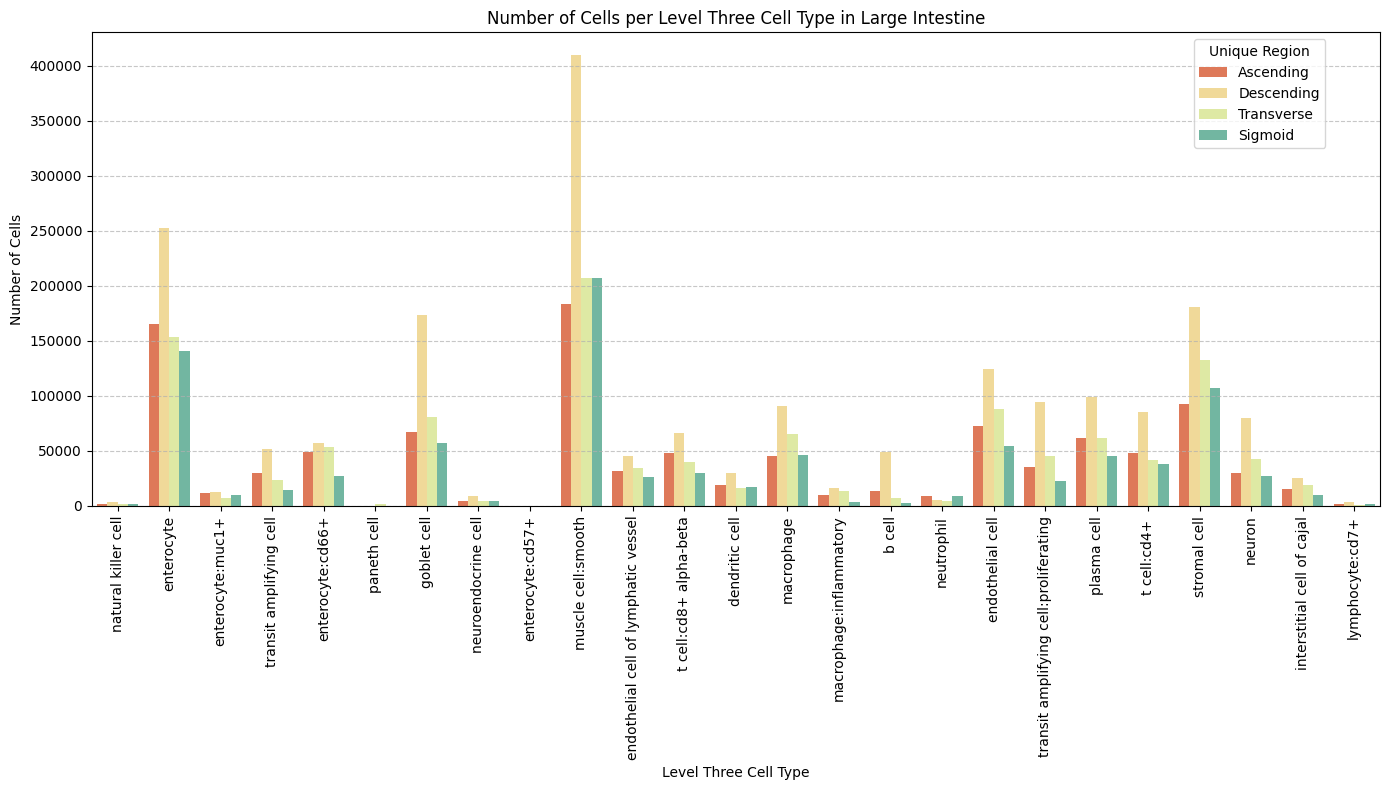

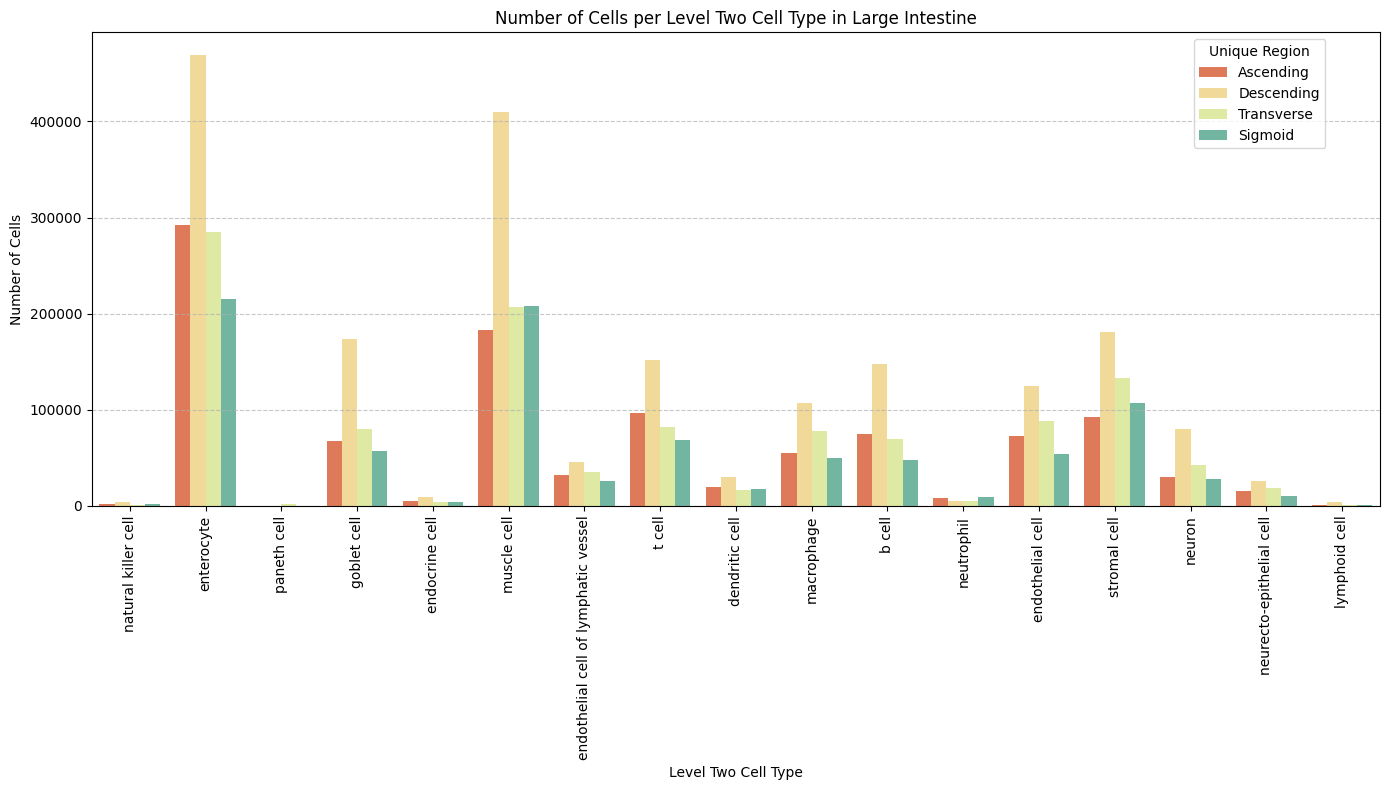

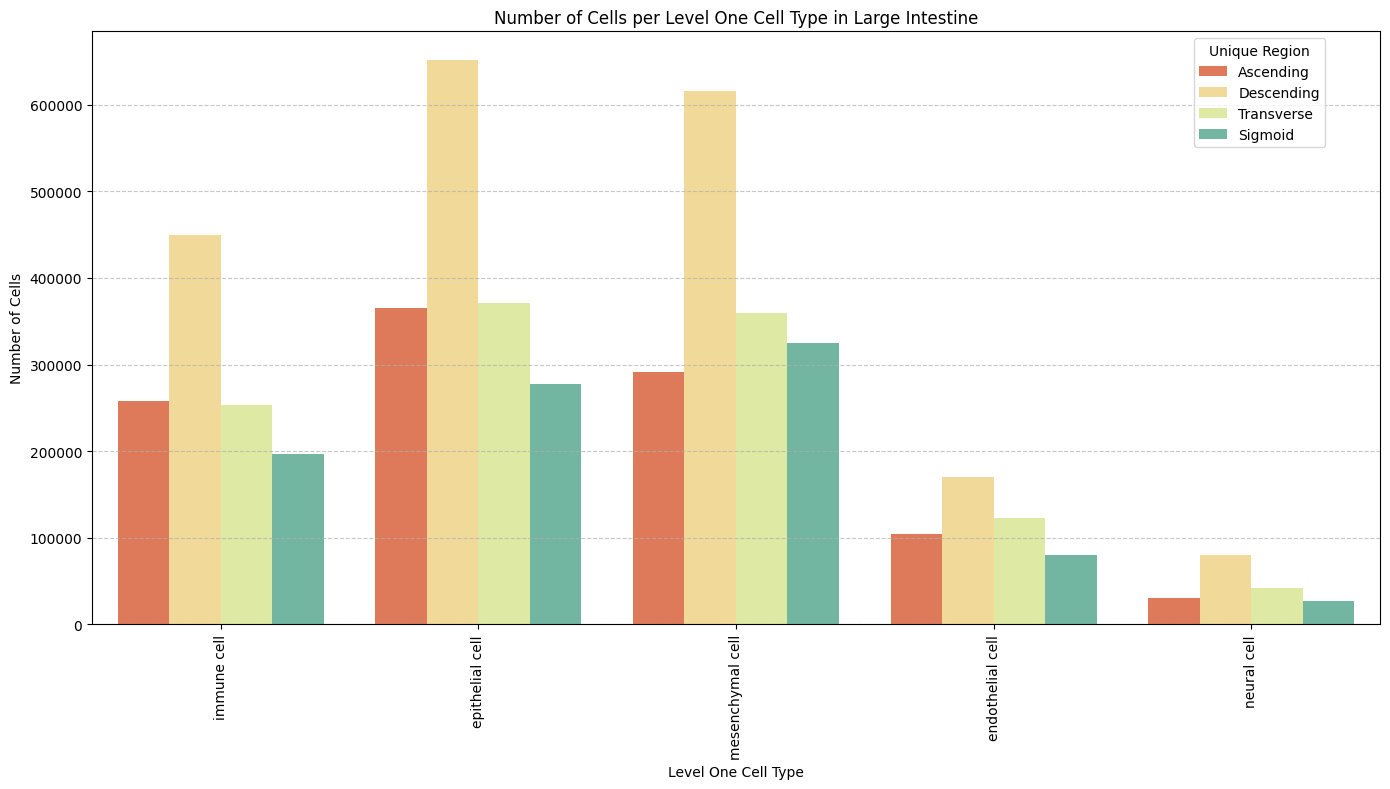

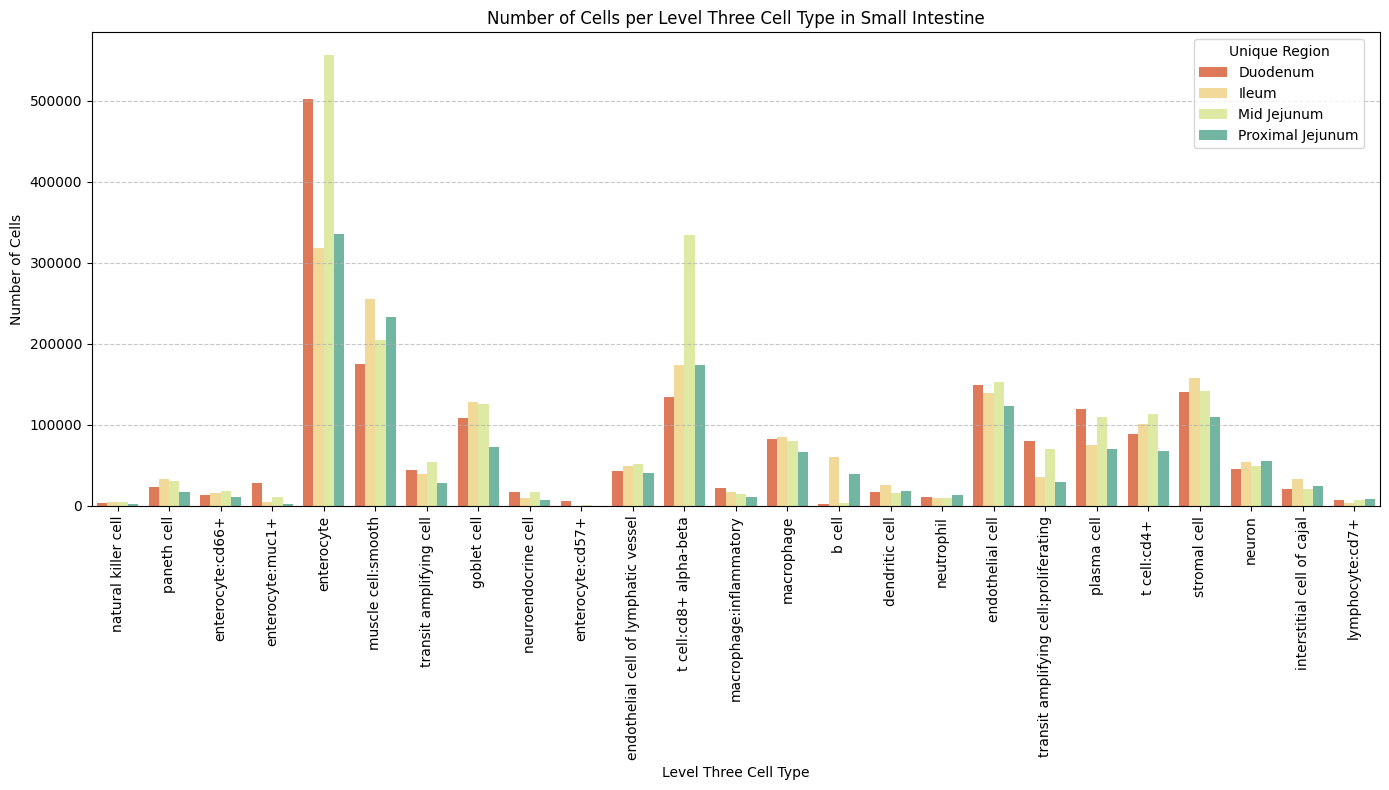

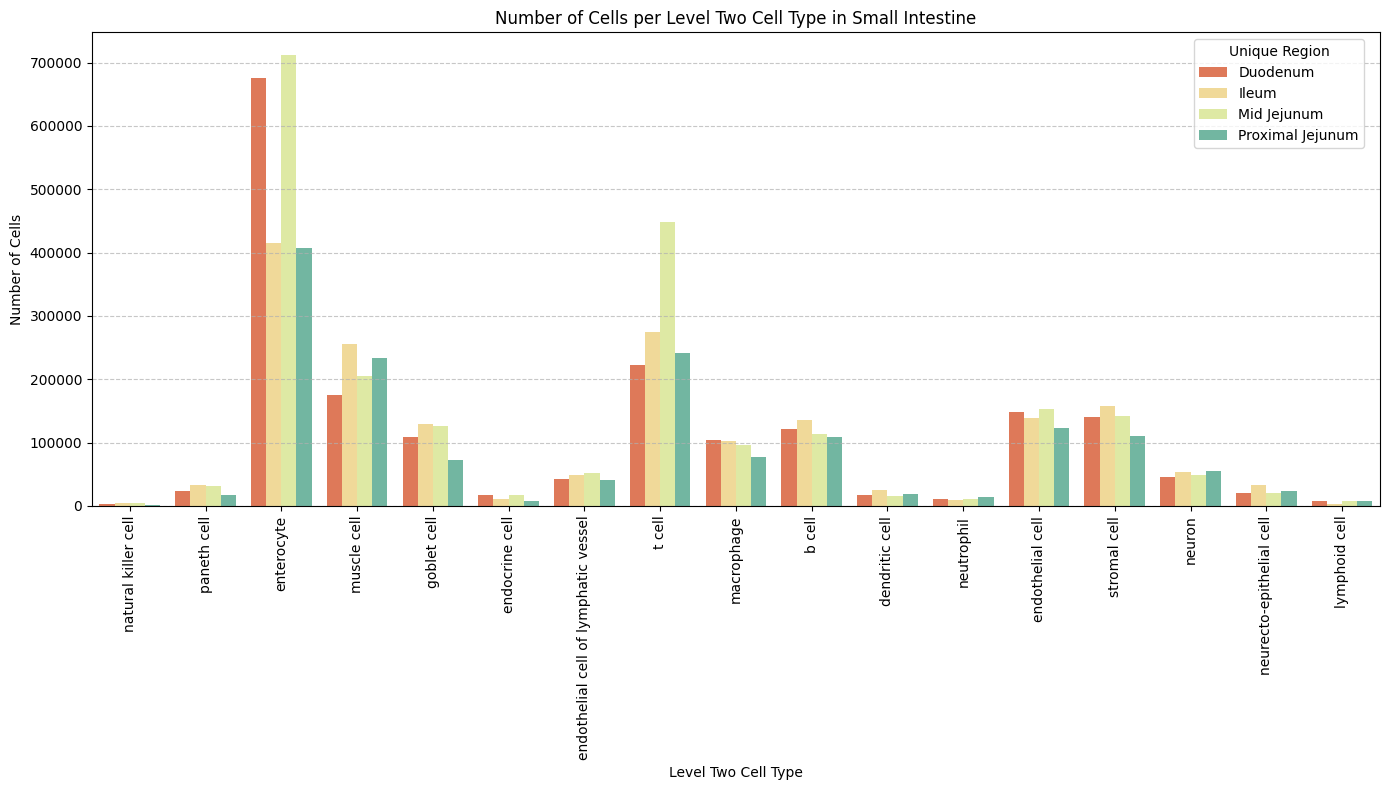

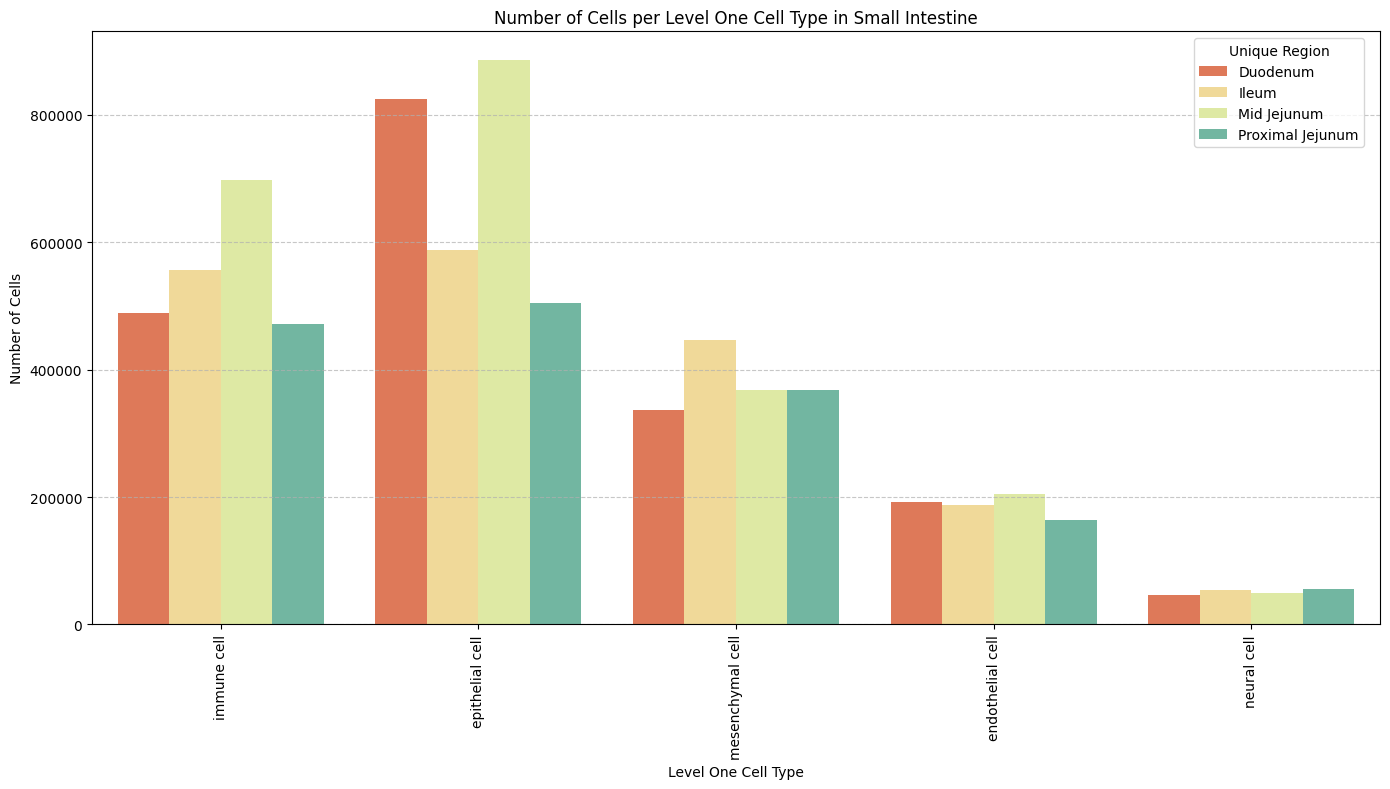

In [23]:
# Plot number of cells per cell type in large intestine in the same plot. Color by cell type and unique region. Output figure saved in existing `figures_output_dir`.
def plot_cells_per_celltype(df, type_field, intestine_type, output_dir):
    plt.figure(figsize=(14, 8))
    sns.countplot(data=df[df['Tissue Subtype'] == intestine_type], x=type_field, palette='Spectral', hue='Unique Region')
    plt.title(f'Number of Cells per {type_field} in {intestine_type}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}_{intestine_type}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}_{intestine_type}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.legend(title='Unique Region', bbox_to_anchor=(0.85, 1), loc='upper left')
    plt.xlabel(type_field)
    plt.ylabel('Number of Cells')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Show the plot
    plt.show()
    plt.close()
for type_field in type_field_list:
    plot_cells_per_celltype(df_all_nodes, type_field, 'Large Intestine', os.path.join(basepath, figures_output_dir))
# Plot number of cells per cell type in small intestine in the same plot. Color by cell type and unique region. Output figure saved in existing `figures_output_dir`.
for type_field in type_field_list:
    plot_cells_per_celltype(df_all_nodes, type_field, 'Small Intestine', os.path.join(basepath, figures_output_dir))

## Distance Analysis

In [24]:
# Get mean, median, minimum, maximum distance per unique region in each tissue subtype per anchor cell type.
df_distance_stats = df_all_edges_with_cell_types.groupby(['Unique Region', 'Tissue Subtype', 'Anchor Cell Type', 'Anchor Cell Type Level']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
# Print the first few rows of the distance statistics DataFrame.
df_distance_stats

,Unique Region,Tissue Subtype,Anchor Cell Type,Anchor Cell Type Level,mean_distance,median_distance,min_distance,max_distance
0,Ascending,Large Intestine,endothelial cell,Level One Cell Type,32.465985,23.412212,0.377420,199.984527
1,Ascending,Large Intestine,endothelial cell,Level Three Cell Type,41.197999,31.965045,0.533752,199.984527
2,Ascending,Large Intestine,endothelial cell,Level Two Cell Type,41.197999,31.965045,0.533752,199.984527
3,Ascending,Large Intestine,endothelial cell of lymphatic vessel,Level Three Cell Type,48.645392,36.122071,0.377420,199.984527
4,Ascending,Large Intestine,endothelial cell of lymphatic vessel,Level Two Cell Type,48.645392,36.122071,0.377420,199.984527
5,Descending,Large Intestine,endothelial cell,Level One Cell Type,33.751636,24.981099,0.000000,199.998416
6,Descending,Large Intestine,endothelial cell,Level Three Cell Type,40.669880,31.271246,0.000000,199.998416
7,Descending,Large Intestine,endothelial cell,Level Two Cell Type,40.669880,31.271246,0.000000,199.998416
8,Descending,Large Intestine,endothelial cell of lymphatic vessel,Level Three Cell Type,55.376327,44.605871,0.377420,199.985951
9,Descending,Large Intestine,endothelial cell of lymphatic vessel,Level Two Cell Type,55.376327,44.605871,0.377420,199.985951


### Level One Cell Type Analysis

In [125]:
# Get mean, median, minimum, maximum distance per cell type in all tissue subtypes.
cell_type_level = 'Level One Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Tissue Subtype']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level One Cell Type,Tissue Subtype,mean_distance,median_distance,min_distance,max_distance
0,epithelial cell,Large Intestine,32.875946,26.085702,0.377420,199.984527
1,epithelial cell,Small Intestine,43.213764,29.083389,0.000000,199.994498
2,immune cell,Large Intestine,25.267128,18.151509,0.000000,199.947128
3,immune cell,Small Intestine,26.838213,17.229543,0.000000,199.987020
4,mesenchymal cell,Large Intestine,42.273309,32.458120,0.000000,199.998416
5,mesenchymal cell,Small Intestine,32.811427,24.166671,0.000000,199.793187
6,neural cell,Large Intestine,37.306252,28.396936,0.377420,198.398031
7,neural cell,Small Intestine,27.669692,20.812925,0.533752,198.517180


In [126]:
# Get top five and bottom five cell types with respect to mean distance in small intestine and large intestine separately.
def get_top_bottom_cell_types(df, cell_type_level, tissue_subtype, top_n=5):
    # Filter the DataFrame for the specified tissue subtype and cell type level
    df_filtered = df[df['Tissue Subtype'] == tissue_subtype]

    # Group by the specified cell type level and calculate mean distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(mean_distance=('Distance', 'mean')).reset_index()
    
    # Sort by mean distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='mean_distance', ascending=False)
    
    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types
# Get top and bottom cell types for small intestine
top_bottom_si = get_top_bottom_cell_types(df_all_edges_with_cell_type_level, cell_type_level, 'Small Intestine')
print("\nTop 5 cell types in Small Intestine:")
print(top_bottom_si[0])
print("\nBottom 5 cell types in Small Intestine:")
print(top_bottom_si[1])
# Get top and bottom cell types for large intestine
top_bottom_li = get_top_bottom_cell_types(df_all_edges_with_cell_type_level, cell_type_level, 'Large Intestine')
print("\nTop 5 cell types in Large Intestine:")
print(top_bottom_li[0])
print("\nBottom 5 cell types in Large Intestine:")
print(top_bottom_li[1])



Top 5 cell types in Small Intestine:
  Level One Cell Type  mean_distance
0     epithelial cell      43.213764
2    mesenchymal cell      32.811427
3         neural cell      27.669692
1         immune cell      26.838213

Bottom 5 cell types in Small Intestine:
  Level One Cell Type  mean_distance
0     epithelial cell      43.213764
2    mesenchymal cell      32.811427
3         neural cell      27.669692
1         immune cell      26.838213

Top 5 cell types in Large Intestine:
  Level One Cell Type  mean_distance
2    mesenchymal cell      42.273309
3         neural cell      37.306252
0     epithelial cell      32.875946
1         immune cell      25.267128

Bottom 5 cell types in Large Intestine:
  Level One Cell Type  mean_distance
2    mesenchymal cell      42.273309
3         neural cell      37.306252
0     epithelial cell      32.875946
1         immune cell      25.267128


In [127]:
# Get top five and bottom five cell types with respect to median distance in small intestine and large intestine separately.
def get_top_bottom_cell_types(df, cell_type_level, tissue_subtype, top_n=5):
    # Filter the DataFrame for the specified tissue subtype and cell type level
    df_filtered = df[df['Tissue Subtype'] == tissue_subtype]

    # Group by the specified cell type level and calculate median distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(median_distance=('Distance', 'median')).reset_index()

    # Sort by median distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='median_distance', ascending=False)
    
    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types
# Get top and bottom cell types for small intestine
top_bottom_si = get_top_bottom_cell_types(df_all_edges_with_cell_type_level, cell_type_level, 'Small Intestine')
print("\nTop 5 cell types in Small Intestine:")
print(top_bottom_si[0])
print("\nBottom 5 cell types in Small Intestine:")
print(top_bottom_si[1])
# Get top and bottom cell types for large intestine
top_bottom_li = get_top_bottom_cell_types(df_all_edges_with_cell_type_level, cell_type_level, 'Large Intestine')
print("\nTop 5 cell types in Large Intestine:")
print(top_bottom_li[0])
print("\nBottom 5 cell types in Large Intestine:")
print(top_bottom_li[1])



Top 5 cell types in Small Intestine:
  Level One Cell Type  median_distance
0     epithelial cell        29.083389
2    mesenchymal cell        24.166671
3         neural cell        20.812925
1         immune cell        17.229543

Bottom 5 cell types in Small Intestine:
  Level One Cell Type  median_distance
0     epithelial cell        29.083389
2    mesenchymal cell        24.166671
3         neural cell        20.812925
1         immune cell        17.229543

Top 5 cell types in Large Intestine:
  Level One Cell Type  median_distance
2    mesenchymal cell        32.458120
3         neural cell        28.396936
0     epithelial cell        26.085702
1         immune cell        18.151509

Bottom 5 cell types in Large Intestine:
  Level One Cell Type  median_distance
2    mesenchymal cell        32.458120
3         neural cell        28.396936
0     epithelial cell        26.085702
1         immune cell        18.151509


In [128]:
# Calculate regional variability
def calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level):
    """    Calculate regional variability for distances in the given DataFrame.
    """
    regional_variability = df_all_edges_with_cell_type_level.groupby('Unique Region')['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    regional_variability['CV (%)'] = (regional_variability['std'] / regional_variability['mean'] * 100).round(1)

    print("\nRegional Variability Analysis:")
    print("Mean: Average distance in each region")
    print("Std: Standard deviation of distances")
    print("CV: Coefficient of Variation (std/mean * 100%)")
    print(regional_variability)

    # Calculate variability for each cell type
    cell_type_variability = df_all_edges_with_cell_type_level.groupby(cell_type_level)['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    cell_type_variability['CV (%)'] = (cell_type_variability['std'] / cell_type_variability['mean'] * 100).round(1)

    print("\nCell Type Variability Analysis (sorted by CV):")
    print(cell_type_variability.sort_values('CV (%)', ascending=False))

calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                   mean    std  CV (%)
Unique Region                         
Ascending         32.47  29.00    89.3
Descending        33.75  28.99    85.9
Duodenum          32.46  31.37    96.6
Ileum             32.58  32.14    98.6
Mid Jejunum       37.49  37.58   100.2
Proximal Jejunum  36.90  35.99    97.5
Sigmoid           37.37  29.56    79.1
Transverse        34.82  29.29    84.1

Cell Type Variability Analysis (sorted by CV):
                      mean    std  CV (%)
Level One Cell Type                      
immune cell          26.29  27.85   105.9
epithelial cell      39.19  35.37    90.3
mesenchymal cell     37.66  31.52    83.7
neural cell          32.18  26.83    83.4


In [129]:
# Define the standard region sequence for plots
regions = ['Duodenum', 'Proximal Jejunum', 'Mid Jejunum', 'Ileum', 'Ascending', 'Transverse', 'Descending', 'Sigmoid']

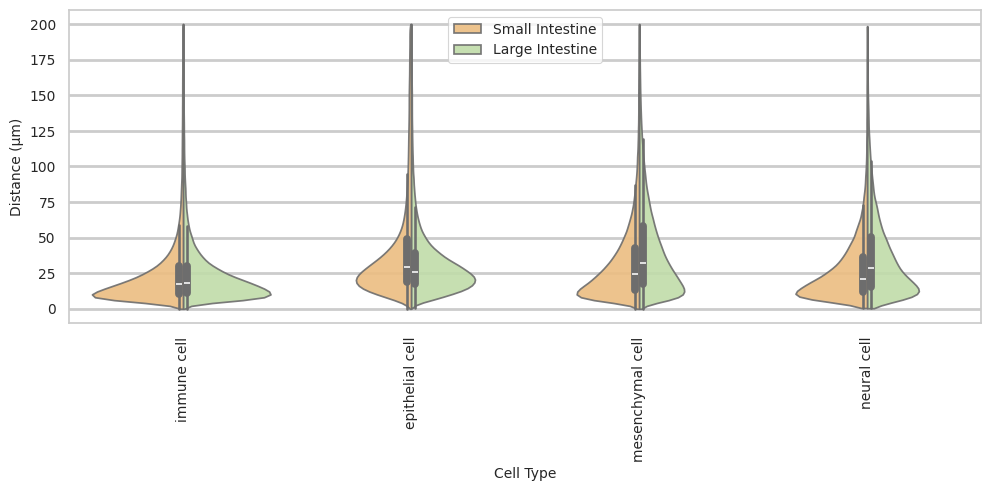

In [130]:
    # Generate Violin Plot
def plot_violin_cells_per_celltype_small_vs_large_intestine(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 2})
    plt.figure(figsize=(10, 5))

    sns.violinplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y="Distance", hue="Tissue Subtype", density_norm="area", common_norm=True, cut=0, inner="box", split=True, palette='Spectral', alpha=.9, hue_order=['Small Intestine', 'Large Intestine'])

    sns.set_theme(style="whitegrid")
    sns.set_context("paper")


    font_size = 10
    plt.legend(fontsize=font_size)

    plt.xlabel('Cell Type', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)

    # Increase font size for all text in the figure
    plt.xticks(fontsize=font_size)
    plt.xticks(rotation=90)
    plt.yticks(fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype__small_vs_large_intestine_{cell_type_level}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype__small_vs_large_intestine_{cell_type_level}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.show()

plot_violin_cells_per_celltype_small_vs_large_intestine(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

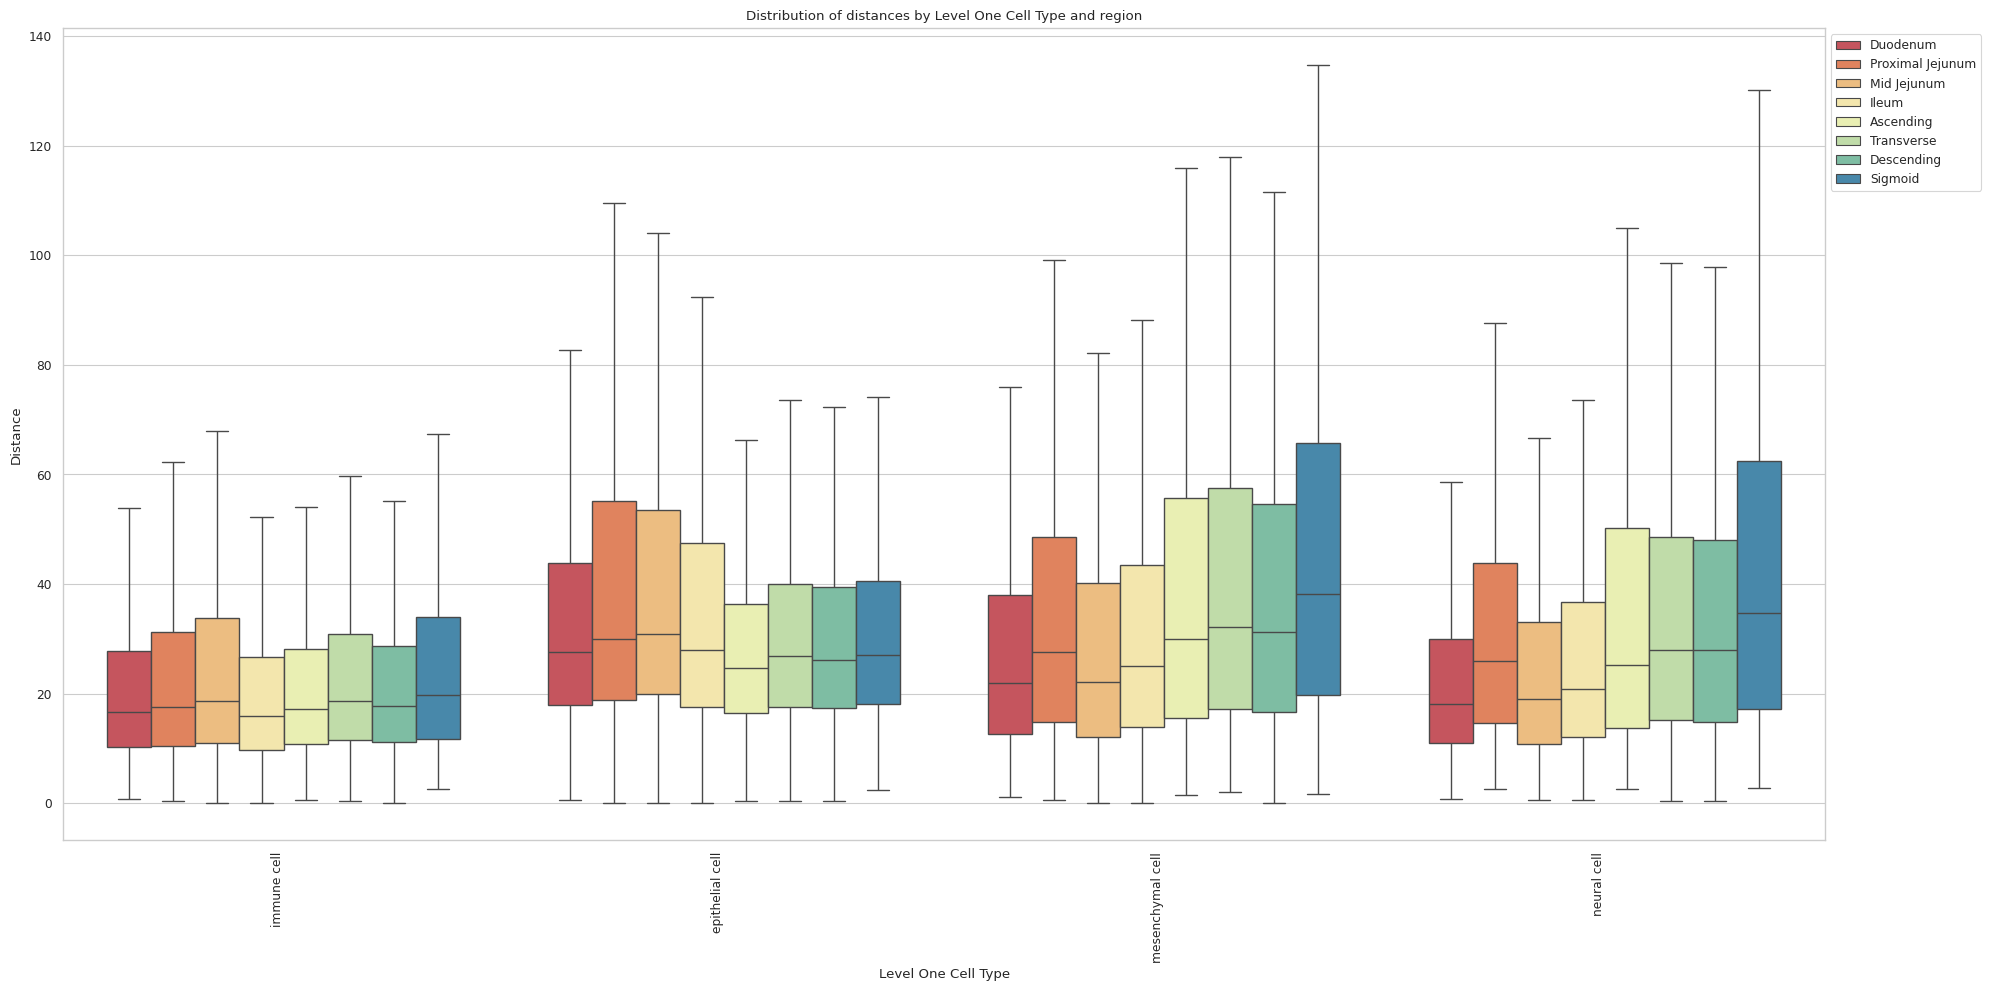

In [131]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    plt.figure(figsize=(20, 10))
    # Create categorical type with only the regions that exist in the data
    available_regions = [r for r in regions if r in df_all_edges_with_cell_type_level['Unique Region'].unique()]
    df_all_edges_with_cell_type_level['Unique Region'] = pd.Categorical(
        df_all_edges_with_cell_type_level['Unique Region'],
        categories=available_regions,
        ordered=True
    )

    sns.boxplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y='Distance', hue='Unique Region', showfliers=False, palette='Spectral') # viridis or Spectral palette for better color distinction
    plt.xticks(rotation=90, ha='right')
    plt.title(f'Distribution of distances by {cell_type_level} and region')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

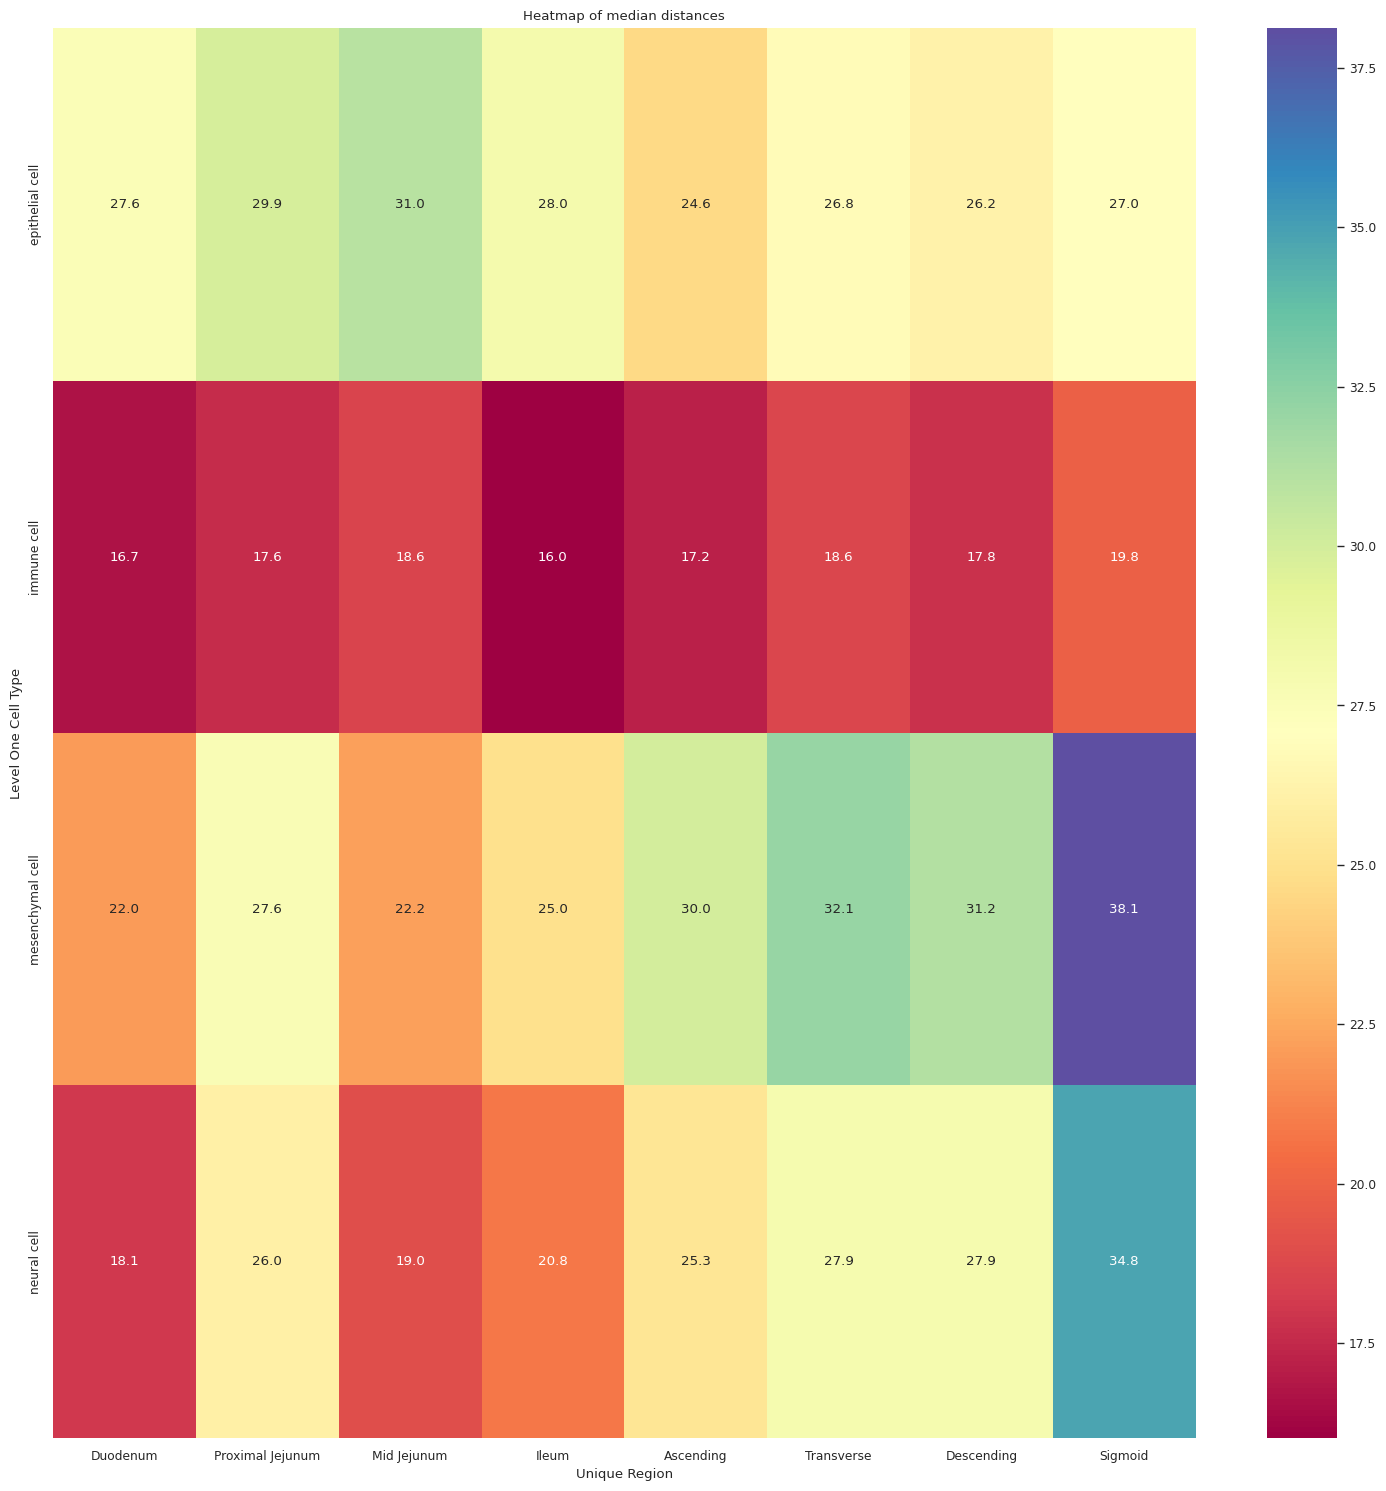

In [132]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    pivot_data = df_all_edges_with_cell_type_level.pivot_table(
    values='Distance',
    index=cell_type_level,
    columns='Unique Region',
    aggfunc='median'
    )

    plt.figure(figsize=(15, 15))
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='Spectral')
    plt.title('Heatmap of median distances')
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

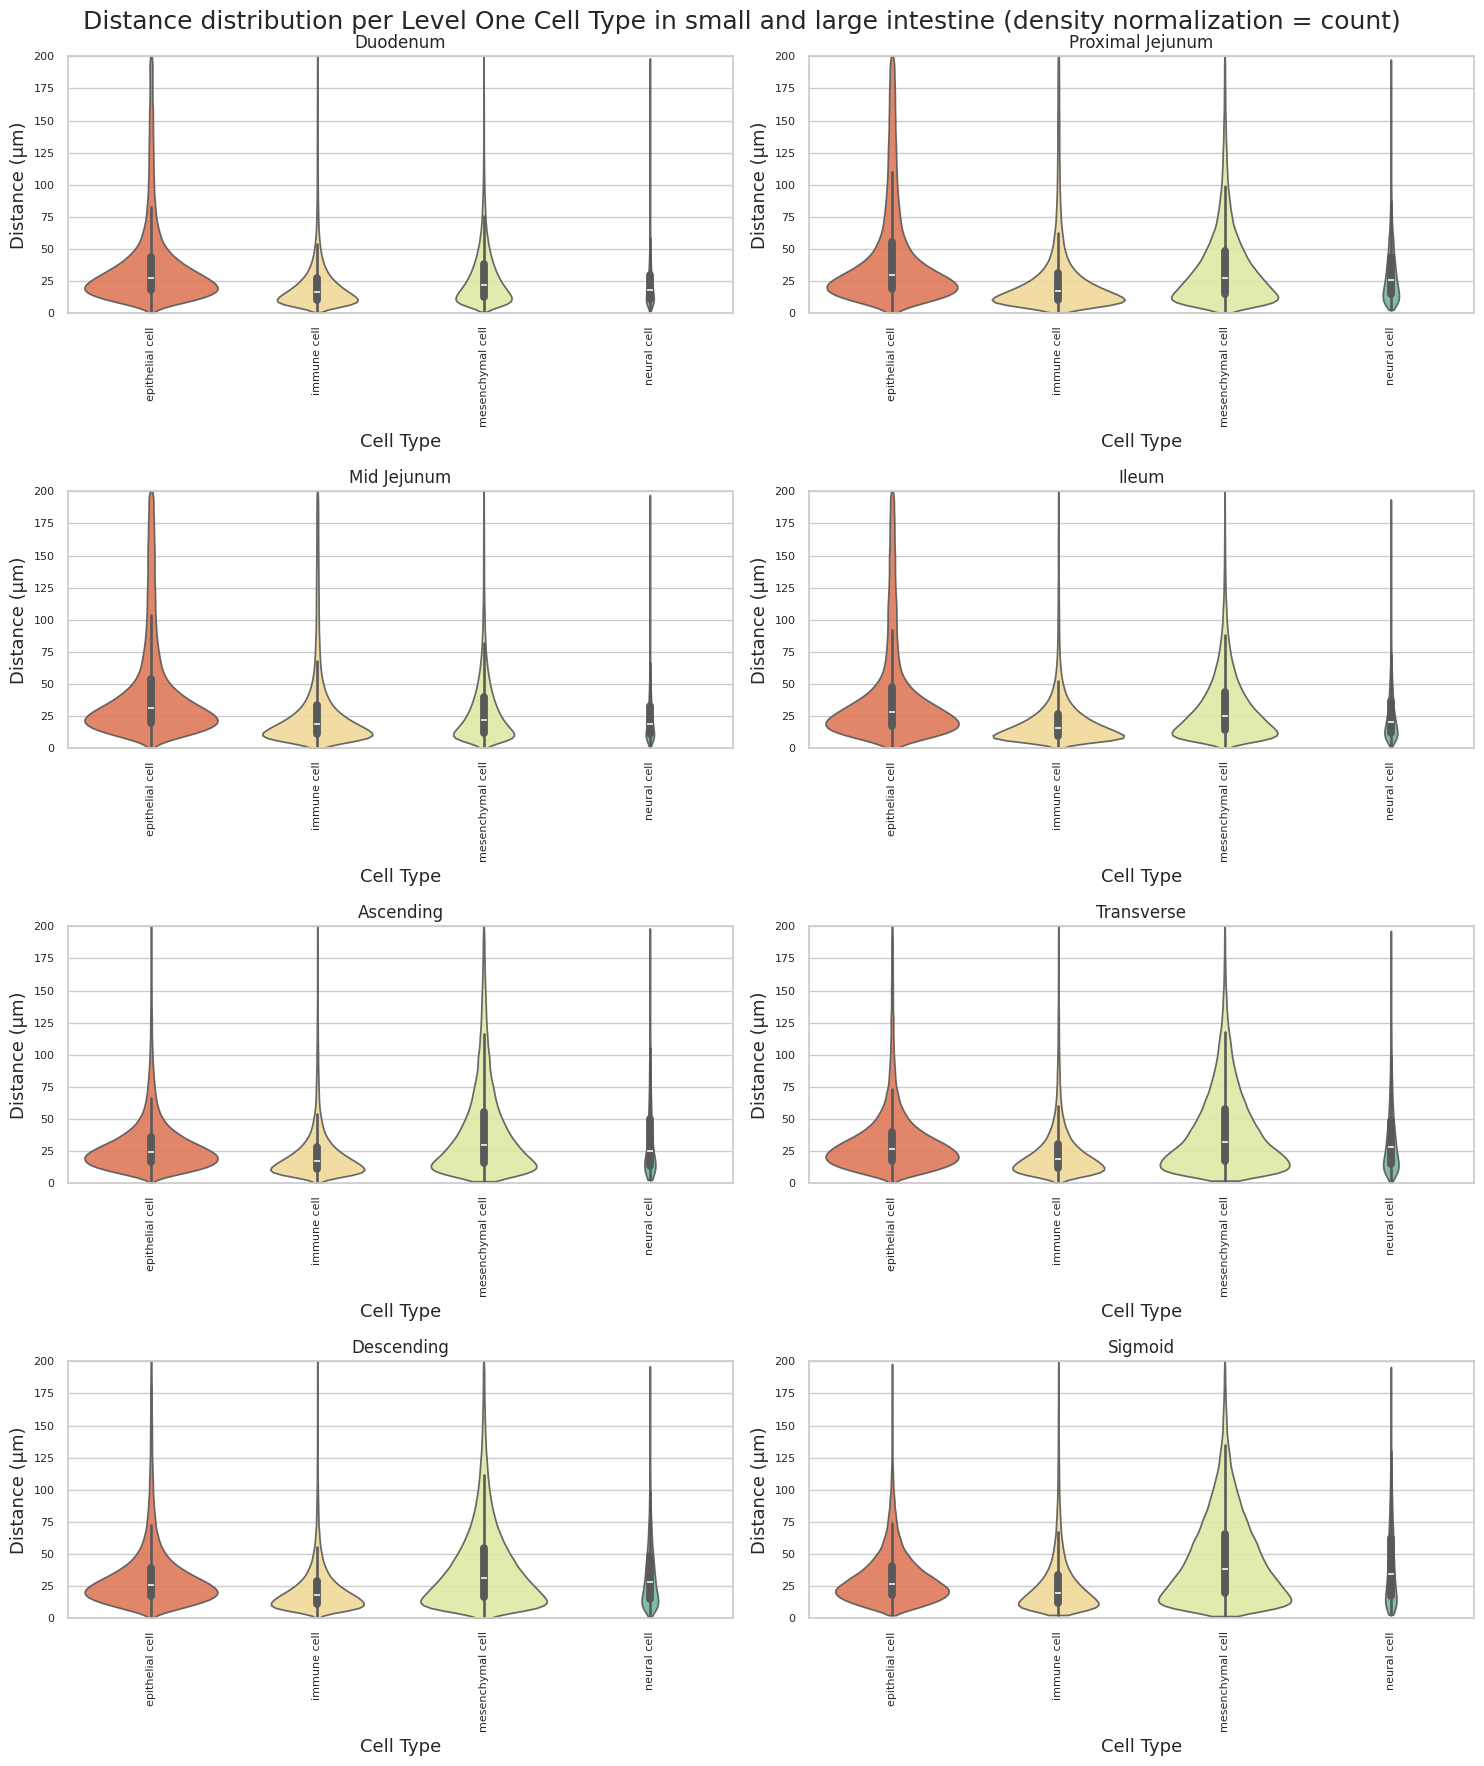

In [133]:
# Generate Violin Plot per unique region in both small intestine and large intestine. Create for all 8 regions as 8 subplots.
def plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm="area"):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 1})

    fig, axs = plt.subplots(4, 2, figsize=(15, 18))
    fig.suptitle(f'Distance distribution per {cell_type_level} in small and large intestine (density normalization = {density_norm})', fontsize=18)

    # Keep the sequence of Cell Types consistent across plots.
    cell_types = sorted(df_all_edges_with_cell_type_level[cell_type_level].unique())

    # Create a color palette based on the number of unique classes
    color_palette = sns.color_palette("Spectral", n_colors=len(cell_types))

    # Create a dictionary mapping class to color
    class_color_dict = dict(zip(cell_types, color_palette))

    for i, region in enumerate(regions):
        data_reg = df_all_edges_with_cell_type_level[df_all_edges_with_cell_type_level['Unique Region'] == region]
        sns.violinplot(data=data_reg, x=cell_type_level, y="Distance", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=False, palette=class_color_dict, alpha=.9, ax=axs[i//2, i%2], hue=cell_type_level, legend=False, order=cell_types, fill=True)
        axs[i//2, i%2].set_title(region)
        axs[i//2, i%2].set_xlabel('Cell Type', fontsize=13)
        axs[i//2, i%2].set_ylabel('Distance (\u03bcm)', fontsize=13)
        axs[i//2, i%2].tick_params(axis='x', labelrotation=90, labelsize=8)
        axs[i//2, i%2].tick_params(axis='both', labelsize=8)
        axs[i//2, i%2].set_ylim(0, 200)
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    
    plt.show()

plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count"

### Level Two Cell Type Analysis

In [134]:
# Get mean, median, minimum, maximum distance per cell type in all tissue subtypes.
cell_type_level = 'Level Two Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Tissue Subtype']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Two Cell Type,Tissue Subtype,mean_distance,median_distance,min_distance,max_distance
0,b cell,Large Intestine,27.053305,21.526179,0.843937,197.546834
1,b cell,Small Intestine,21.818137,17.894644,0.000000,191.707070
2,dendritic cell,Large Intestine,28.327602,21.410062,0.843937,198.968722
3,dendritic cell,Small Intestine,22.322890,16.056992,0.377420,198.825486
4,endocrine cell,Large Intestine,36.294670,31.225661,1.601257,199.648045
5,endocrine cell,Small Intestine,40.786922,31.225661,1.193507,199.569903
6,endothelial cell of lymphatic vessel,Large Intestine,37.245417,27.113891,0.377420,199.705116
7,endothelial cell of lymphatic vessel,Small Intestine,26.096485,17.802866,0.377420,199.313497
8,enterocyte,Large Intestine,41.954515,34.853669,0.377420,199.984527
9,enterocyte,Small Intestine,49.309524,34.872056,0.000000,199.987020


In [135]:
# Get top five and bottom five cell types with respect to mean distance in small intestine and large intestine separately.
def get_top_bottom_cell_types(df, cell_type_level, tissue_subtype, top_n=5):
    # Filter the DataFrame for the specified tissue subtype and cell type level
    df_filtered = df[df['Tissue Subtype'] == tissue_subtype]

    # Group by the specified cell type level and calculate mean distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(mean_distance=('Distance', 'mean')).reset_index()
    
    # Sort by mean distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='mean_distance', ascending=False)
    
    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types
# Get top and bottom cell types for small intestine
top_bottom_si = get_top_bottom_cell_types(df_all_edges_with_cell_type_level, cell_type_level, 'Small Intestine')
print("\nTop 5 cell types in Small Intestine:")
print(top_bottom_si[0])
print("\nBottom 5 cell types in Small Intestine:")
print(top_bottom_si[1])
# Get top and bottom cell types for large intestine
top_bottom_li = get_top_bottom_cell_types(df_all_edges_with_cell_type_level, cell_type_level, 'Large Intestine')
print("\nTop 5 cell types in Large Intestine:")
print(top_bottom_li[0])
print("\nBottom 5 cell types in Large Intestine:")
print(top_bottom_li[1])



Top 5 cell types in Small Intestine:
   Level Two Cell Type  mean_distance
6        lymphoid cell      63.133067
4           enterocyte      49.309524
14        stromal cell      45.676768
5          goblet cell      42.001191
2       endocrine cell      40.786922

Bottom 5 cell types in Small Intestine:
                     Level Two Cell Type  mean_distance
7                             macrophage      28.724084
10              neurecto-epithelial cell      27.136101
3   endothelial cell of lymphatic vessel      26.096485
1                         dendritic cell      22.322890
0                                 b cell      21.818137

Top 5 cell types in Large Intestine:
   Level Two Cell Type  mean_distance
13         paneth cell     138.624783
14        stromal cell      53.780477
8          muscle cell      53.677561
11              neuron      48.971272
4           enterocyte      41.954515

Bottom 5 cell types in Large Intestine:
    Level Two Cell Type  mean_distance
2        en

In [136]:
# Get top five and bottom five cell types with respect to median distance in small intestine and large intestine separately.
def get_top_bottom_cell_types(df, cell_type_level, tissue_subtype, top_n=5):
    # Filter the DataFrame for the specified tissue subtype and cell type level
    df_filtered = df[df['Tissue Subtype'] == tissue_subtype]

    # Group by the specified cell type level and calculate median distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(median_distance=('Distance', 'median')).reset_index()

    # Sort by median distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='median_distance', ascending=False)
    
    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types
# Get top and bottom cell types for small intestine
top_bottom_si = get_top_bottom_cell_types(df_all_edges_with_cell_type_level, cell_type_level, 'Small Intestine')
print("\nTop 5 cell types in Small Intestine:")
print(top_bottom_si[0])
print("\nBottom 5 cell types in Small Intestine:")
print(top_bottom_si[1])
# Get top and bottom cell types for large intestine
top_bottom_li = get_top_bottom_cell_types(df_all_edges_with_cell_type_level, cell_type_level, 'Large Intestine')
print("\nTop 5 cell types in Large Intestine:")
print(top_bottom_li[0])
print("\nBottom 5 cell types in Large Intestine:")
print(top_bottom_li[1])



Top 5 cell types in Small Intestine:
   Level Two Cell Type  median_distance
6        lymphoid cell        43.305553
4           enterocyte        34.872056
14        stromal cell        33.698344
5          goblet cell        32.346017
2       endocrine cell        31.225661

Bottom 5 cell types in Small Intestine:
                     Level Two Cell Type  median_distance
12                            neutrophil        18.431857
7                             macrophage        18.041308
0                                 b cell        17.894644
3   endothelial cell of lymphatic vessel        17.802866
1                         dendritic cell        16.056992

Top 5 cell types in Large Intestine:
   Level Two Cell Type  median_distance
13         paneth cell       154.596150
8          muscle cell        45.674058
14        stromal cell        41.228708
11              neuron        39.629100
4           enterocyte        34.853669

Bottom 5 cell types in Large Intestine:
    Level Two 

In [137]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                   mean    std  CV (%)
Unique Region                         
Ascending         41.20  32.11    77.9
Descending        40.67  32.26    79.3
Duodenum          36.24  32.45    89.5
Ileum             37.43  33.54    89.6
Mid Jejunum       41.19  37.64    91.4
Proximal Jejunum  41.26  36.84    89.3
Sigmoid           48.92  35.83    73.2
Transverse        44.69  33.58    75.1

Cell Type Variability Analysis (sorted by CV):
                                       mean    std  CV (%)
Level Two Cell Type                                       
neutrophil                            35.60  38.33   107.7
natural killer cell                   33.64  33.72   100.2
macrophage                            34.30  34.07    99.3
t cell                                33.65  32.40    96.3
neurecto-epithelial cell              31.59  29.57    

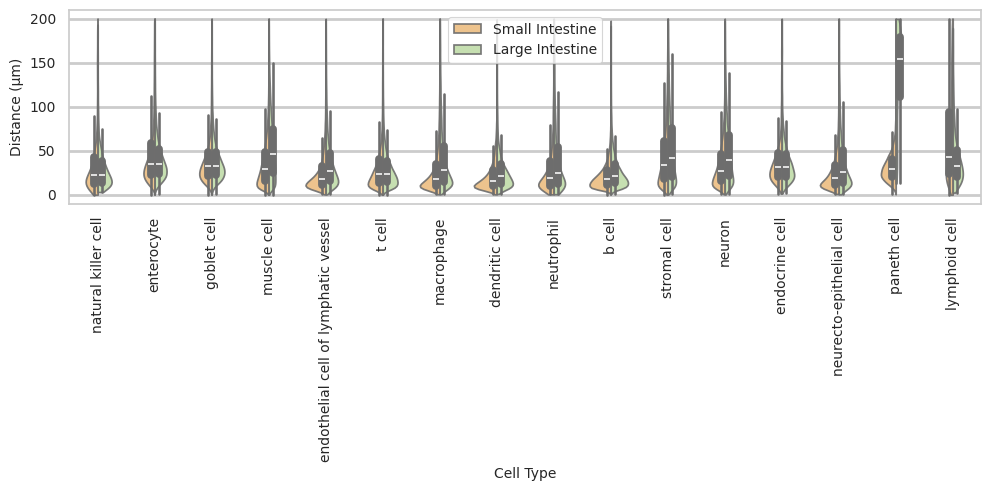

In [138]:
plot_violin_cells_per_celltype_small_vs_large_intestine(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

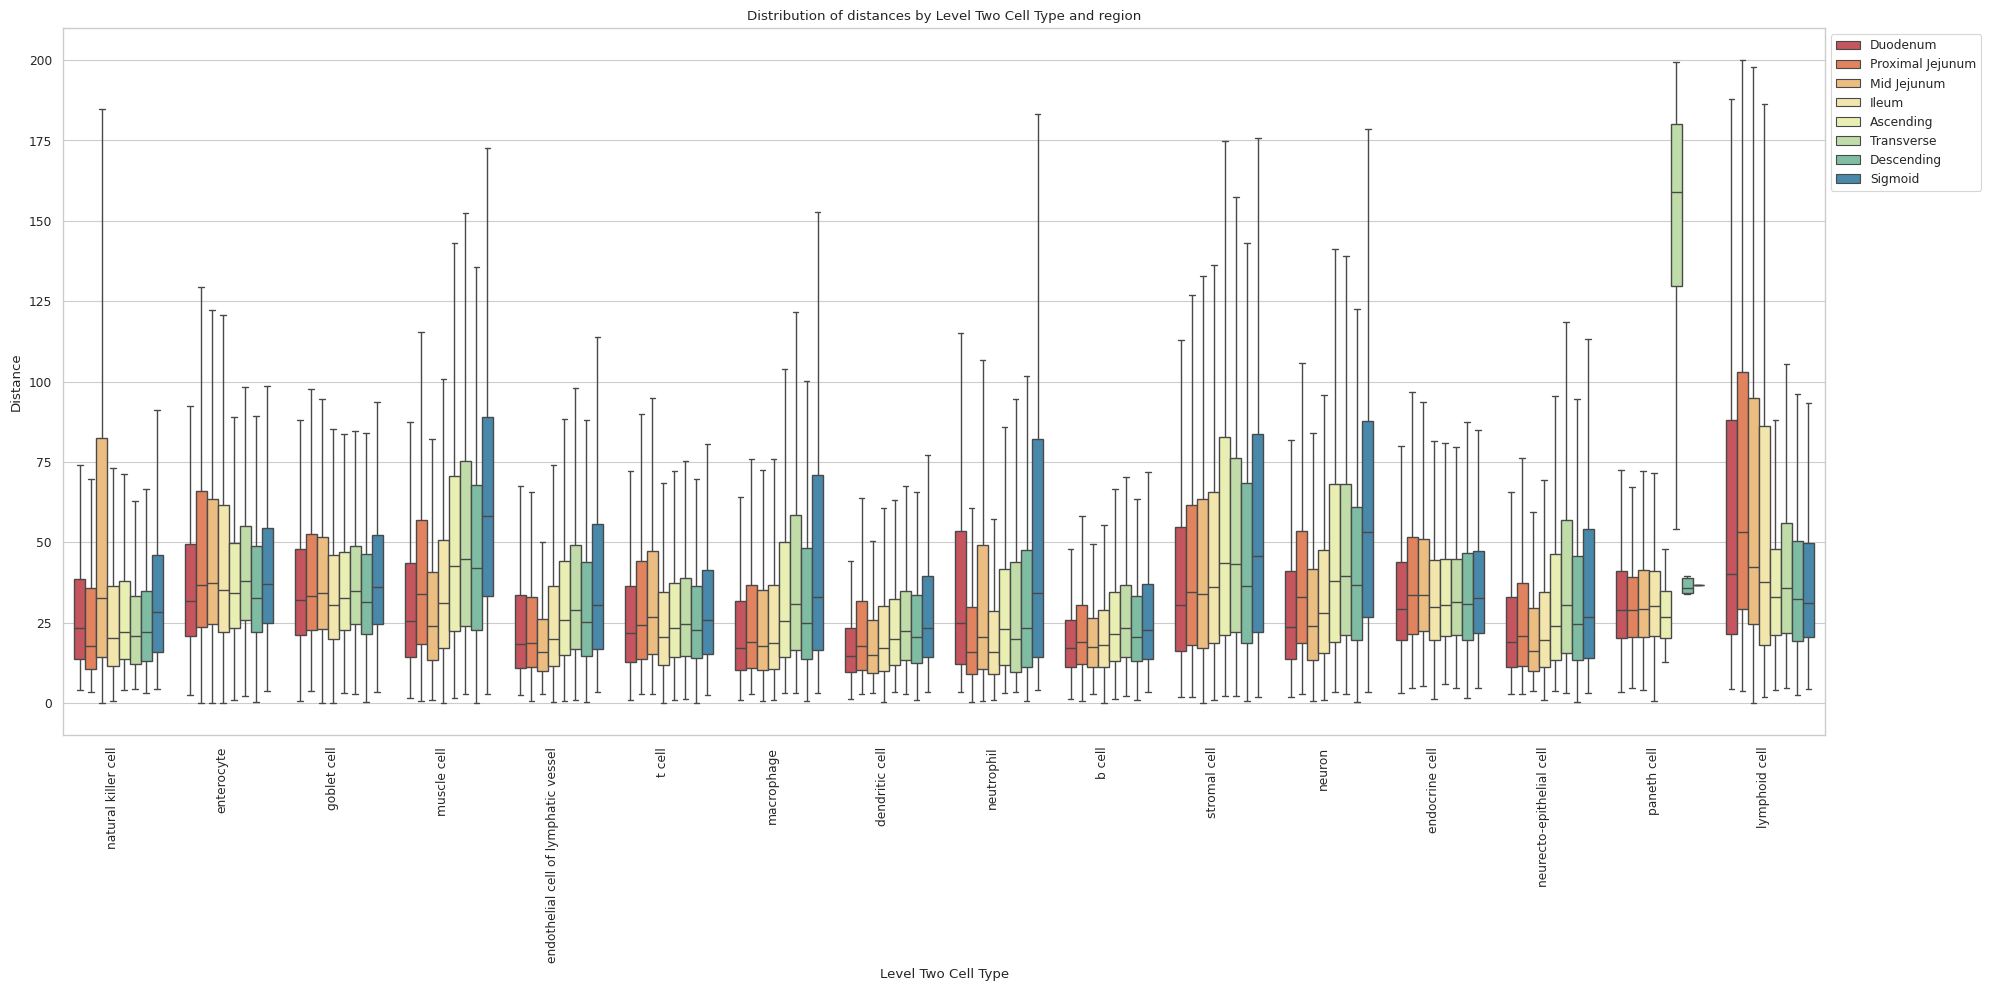

In [139]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

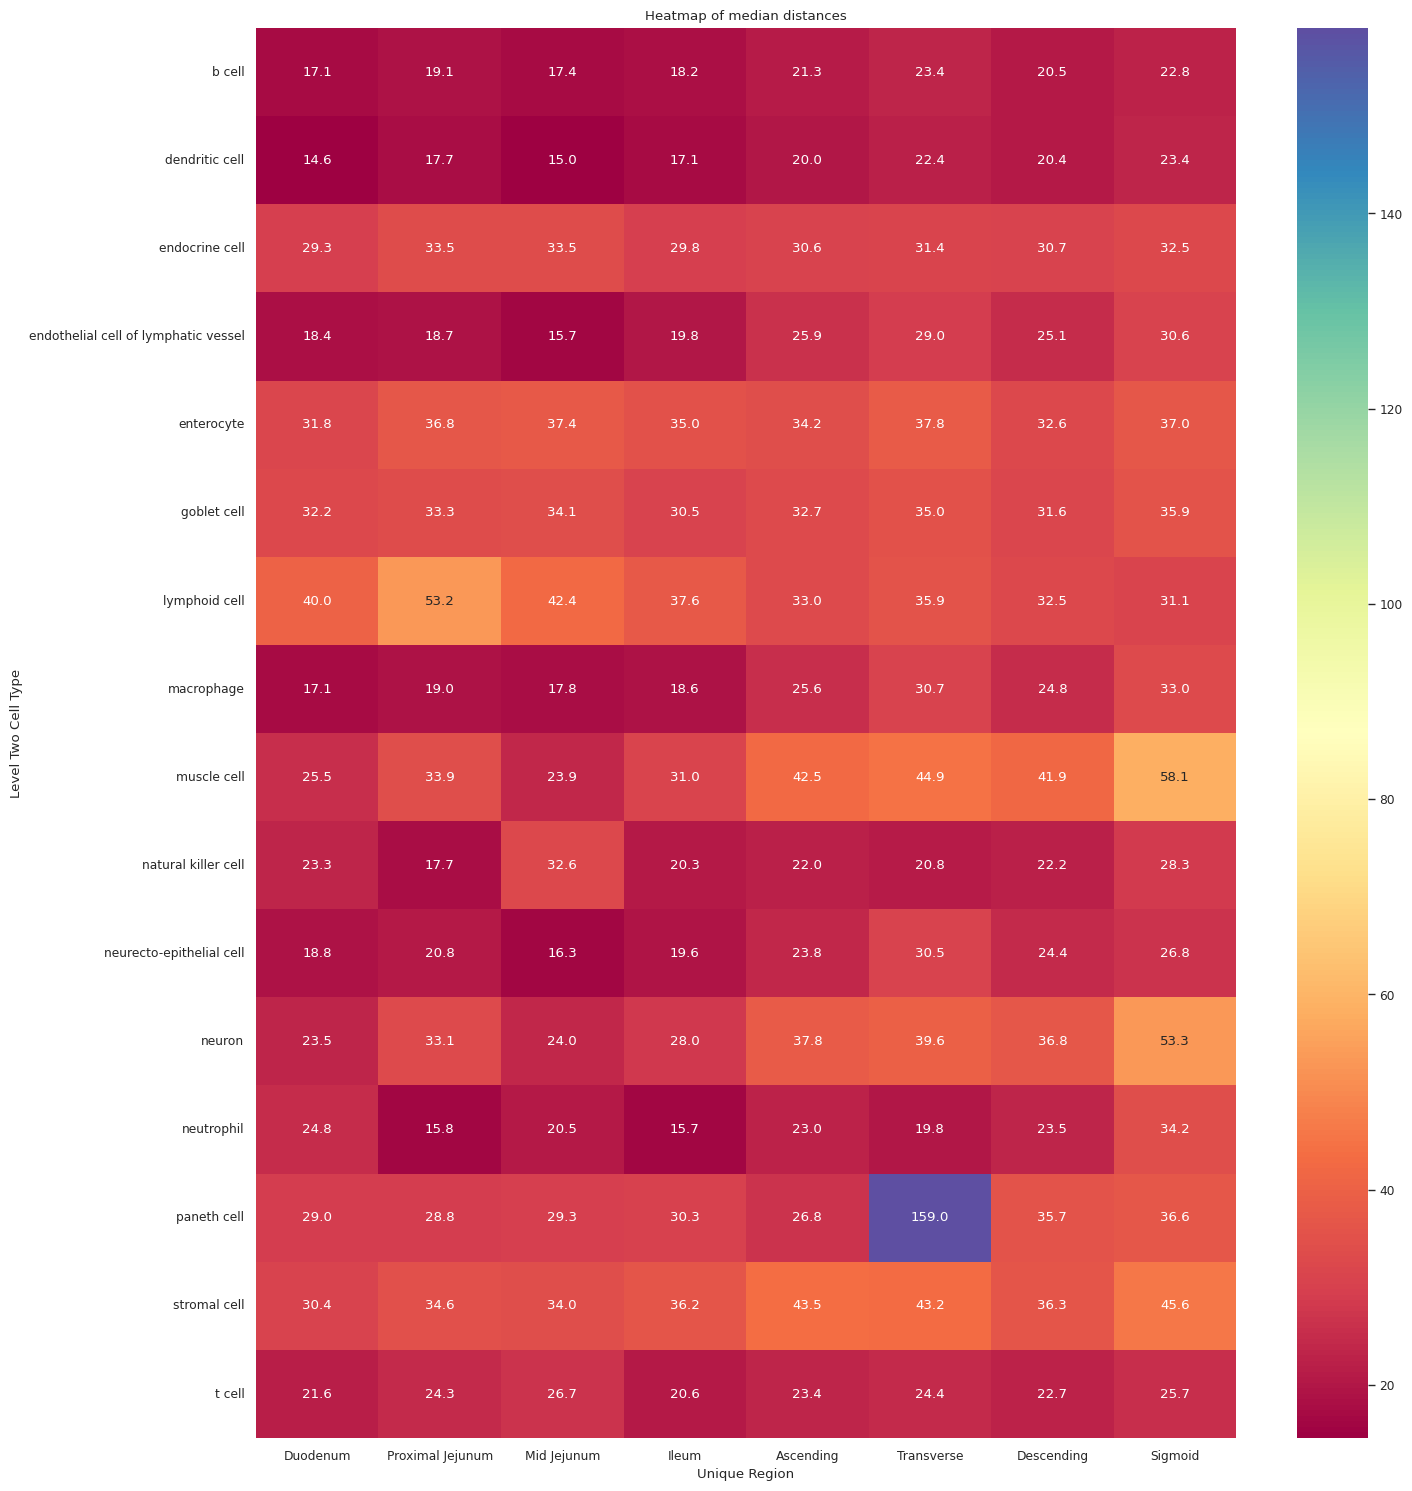

In [140]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

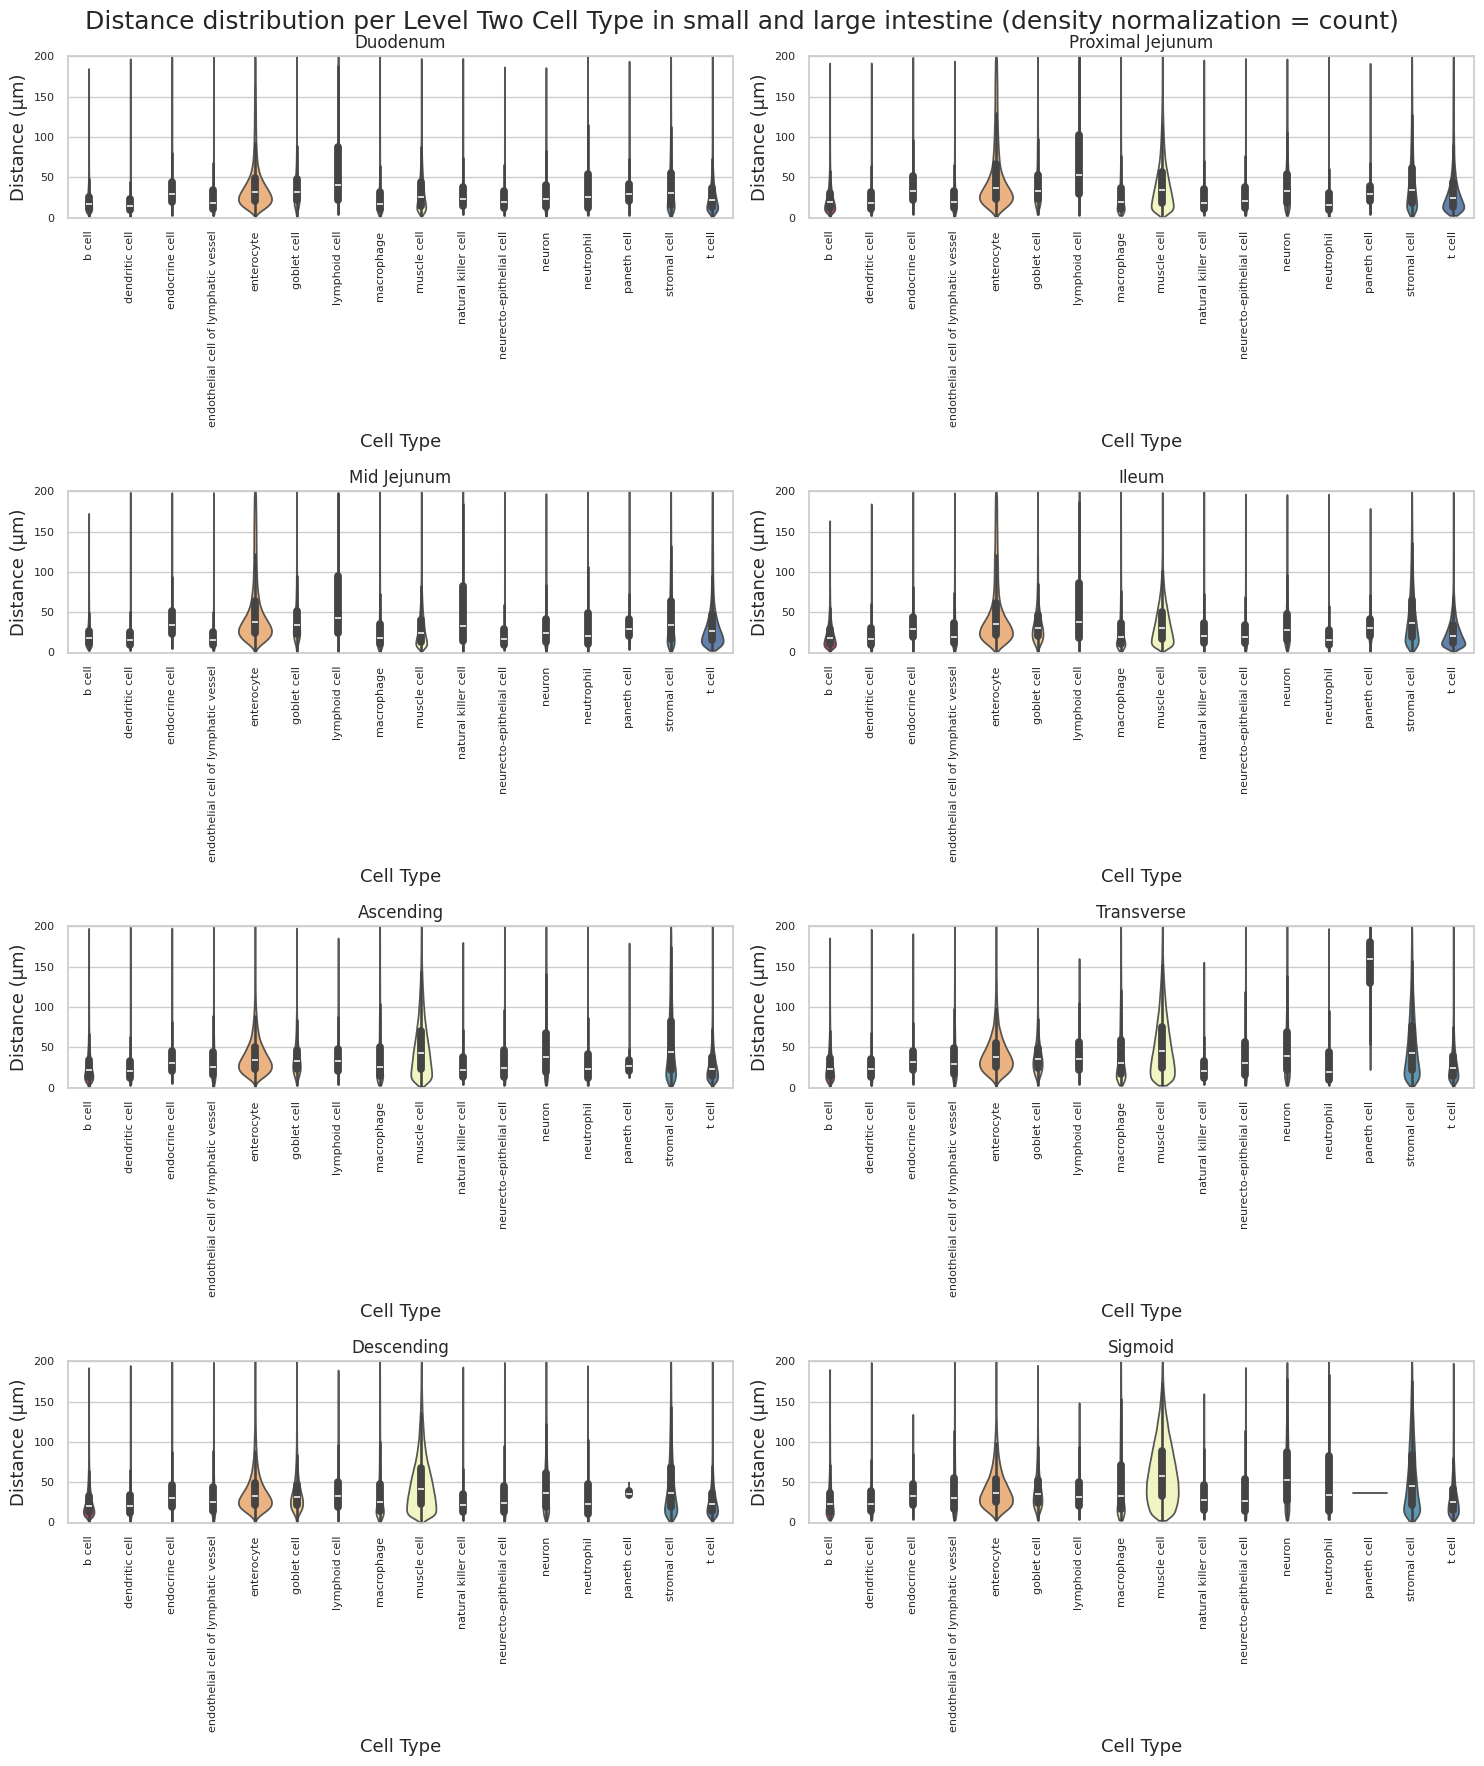

In [141]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count"

### Level Three Cell Type Analysis

In [142]:
# Get mean, median, minimum, maximum distance per cell type in all tissue subtypes.
cell_type_level = 'Level Three Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Tissue Subtype']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Three Cell Type,Tissue Subtype,mean_distance,median_distance,min_distance,max_distance
0,b cell,Large Intestine,29.018398,22.347599,1.193507,195.356325
1,b cell,Small Intestine,27.518600,22.960665,0.377420,156.771564
2,dendritic cell,Large Intestine,28.327602,21.410062,0.843937,198.968722
3,dendritic cell,Small Intestine,22.322890,16.056992,0.377420,198.825486
4,endothelial cell of lymphatic vessel,Large Intestine,37.245417,27.113891,0.377420,199.705116
5,endothelial cell of lymphatic vessel,Small Intestine,26.096485,17.802866,0.377420,199.313497
6,enterocyte,Large Intestine,39.822866,33.086197,0.377420,199.984527
7,enterocyte,Small Intestine,50.623921,35.085853,0.000000,199.977404
8,enterocyte:cd57+,Large Intestine,33.451914,30.388738,2.641940,156.161145
9,enterocyte:cd57+,Small Intestine,31.409334,25.782228,3.717156,199.954608


In [143]:
# Get top five and bottom five cell types with respect to mean distance in small intestine and large intestine separately.
def get_top_bottom_cell_types(df, cell_type_level, tissue_subtype, top_n=5):
    # Filter the DataFrame for the specified tissue subtype and cell type level
    df_filtered = df[df['Tissue Subtype'] == tissue_subtype]

    # Group by the specified cell type level and calculate mean distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(mean_distance=('Distance', 'mean')).reset_index()
    
    # Sort by mean distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='mean_distance', ascending=False)
    
    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types
# Get top and bottom cell types for small intestine
top_bottom_si = get_top_bottom_cell_types(df_all_edges_with_cell_type_level, cell_type_level, 'Small Intestine')
print("\nTop 5 cell types in Small Intestine:")
print(top_bottom_si[0])
print("\nBottom 5 cell types in Small Intestine:")
print(top_bottom_si[1])
# Get top and bottom cell types for large intestine
top_bottom_li = get_top_bottom_cell_types(df_all_edges_with_cell_type_level, cell_type_level, 'Large Intestine')
print("\nTop 5 cell types in Large Intestine:")
print(top_bottom_li[0])
print("\nBottom 5 cell types in Large Intestine:")
print(top_bottom_li[1])



Top 5 cell types in Small Intestine:
      Level Three Cell Type  mean_distance
5          enterocyte:cd66+      77.146245
9           lymphocyte:cd7+      63.133067
3                enterocyte      50.623921
22  transit amplifying cell      47.585919
19             stromal cell      45.676768

Bottom 5 cell types in Small Intestine:
                   Level Three Cell Type  mean_distance
2   endothelial cell of lymphatic vessel      26.096485
20                          t cell:cd4+       23.445133
1                         dendritic cell      22.322890
18                           plasma cell      20.214029
11               macrophage:inflammatory      18.758805

Top 5 cell types in Large Intestine:
   Level Three Cell Type  mean_distance
17           paneth cell     138.624783
5       enterocyte:cd66+      54.150643
19          stromal cell      53.780477
12    muscle cell:smooth      53.677561
15                neuron      48.971272

Bottom 5 cell types in Large Intestine:
      Le

In [144]:
# Get top five and bottom five cell types with respect to median distance in small intestine and large intestine separately.
def get_top_bottom_cell_types(df, cell_type_level, tissue_subtype, top_n=5):
    # Filter the DataFrame for the specified tissue subtype and cell type level
    df_filtered = df[df['Tissue Subtype'] == tissue_subtype]

    # Group by the specified cell type level and calculate median distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(median_distance=('Distance', 'median')).reset_index()

    # Sort by median distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='median_distance', ascending=False)
    
    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types
# Get top and bottom cell types for small intestine
top_bottom_si = get_top_bottom_cell_types(df_all_edges_with_cell_type_level, cell_type_level, 'Small Intestine')
print("\nTop 5 cell types in Small Intestine:")
print(top_bottom_si[0])
print("\nBottom 5 cell types in Small Intestine:")
print(top_bottom_si[1])
# Get top and bottom cell types for large intestine
top_bottom_li = get_top_bottom_cell_types(df_all_edges_with_cell_type_level, cell_type_level, 'Large Intestine')
print("\nTop 5 cell types in Large Intestine:")
print(top_bottom_li[0])
print("\nBottom 5 cell types in Large Intestine:")
print(top_bottom_li[1])



Top 5 cell types in Small Intestine:
      Level Three Cell Type  median_distance
5          enterocyte:cd66+        62.703991
9           lymphocyte:cd7+        43.305553
22  transit amplifying cell        35.930304
3                enterocyte        35.085853
19             stromal cell        33.698344

Bottom 5 cell types in Small Intestine:
                   Level Three Cell Type  median_distance
2   endothelial cell of lymphatic vessel        17.802866
20                          t cell:cd4+         17.802866
18                           plasma cell        16.849172
1                         dendritic cell        16.056992
11               macrophage:inflammatory        12.986758

Top 5 cell types in Large Intestine:
   Level Three Cell Type  median_distance
17           paneth cell       154.596150
12    muscle cell:smooth        45.674058
5       enterocyte:cd66+        44.593095
19          stromal cell        41.228708
6       enterocyte:muc1+        40.120296

Bottom 5 cel

In [145]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                   mean    std  CV (%)
Unique Region                         
Ascending         41.20  32.11    77.9
Descending        40.67  32.26    79.3
Duodenum          36.24  32.45    89.5
Ileum             37.43  33.54    89.6
Mid Jejunum       41.19  37.64    91.4
Proximal Jejunum  41.26  36.84    89.3
Sigmoid           48.92  35.83    73.2
Transverse        44.69  33.58    75.1

Cell Type Variability Analysis (sorted by CV):
                                        mean    std  CV (%)
Level Three Cell Type                                      
neutrophil                             35.60  38.33   107.7
natural killer cell                    33.64  33.72   100.2
macrophage                             36.69  35.65    97.2
t cell:cd8+ alpha-beta                 39.10  37.03    94.7
interstitial cell of cajal             31.59  29

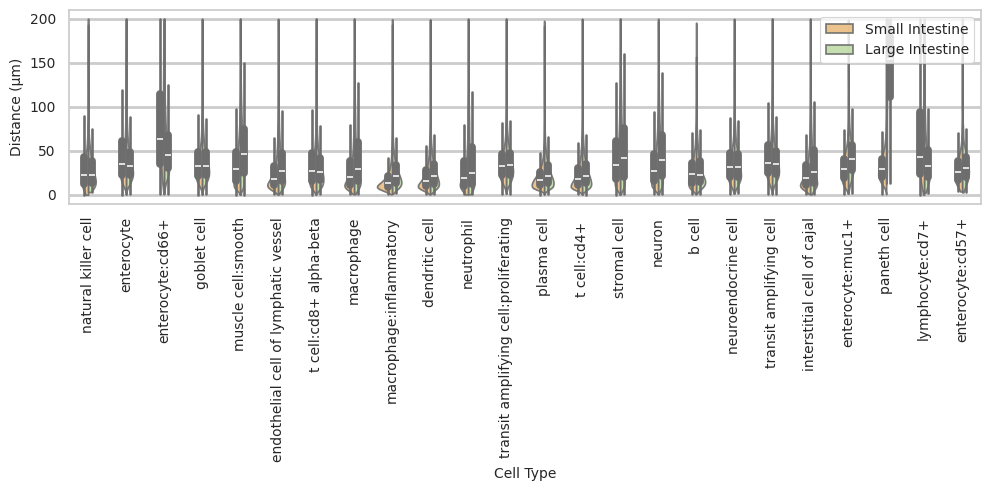

In [146]:
plot_violin_cells_per_celltype_small_vs_large_intestine(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

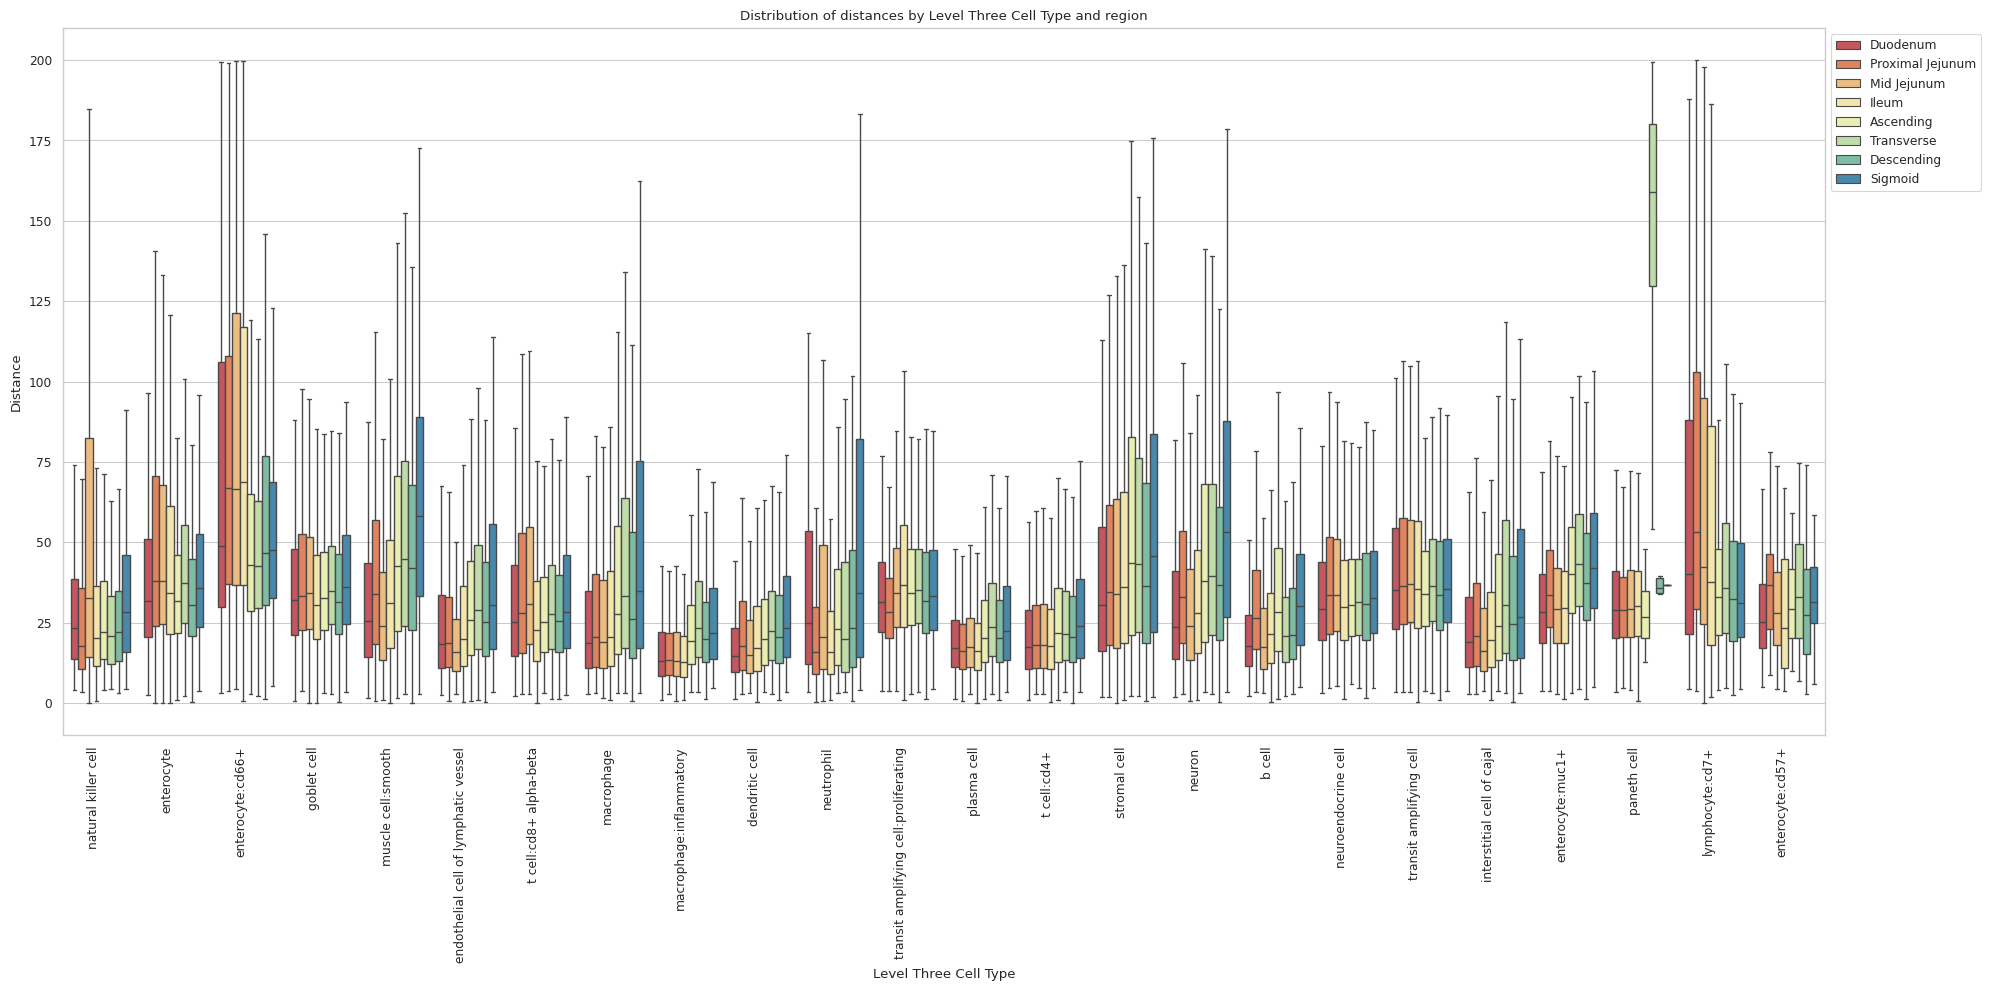

In [147]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

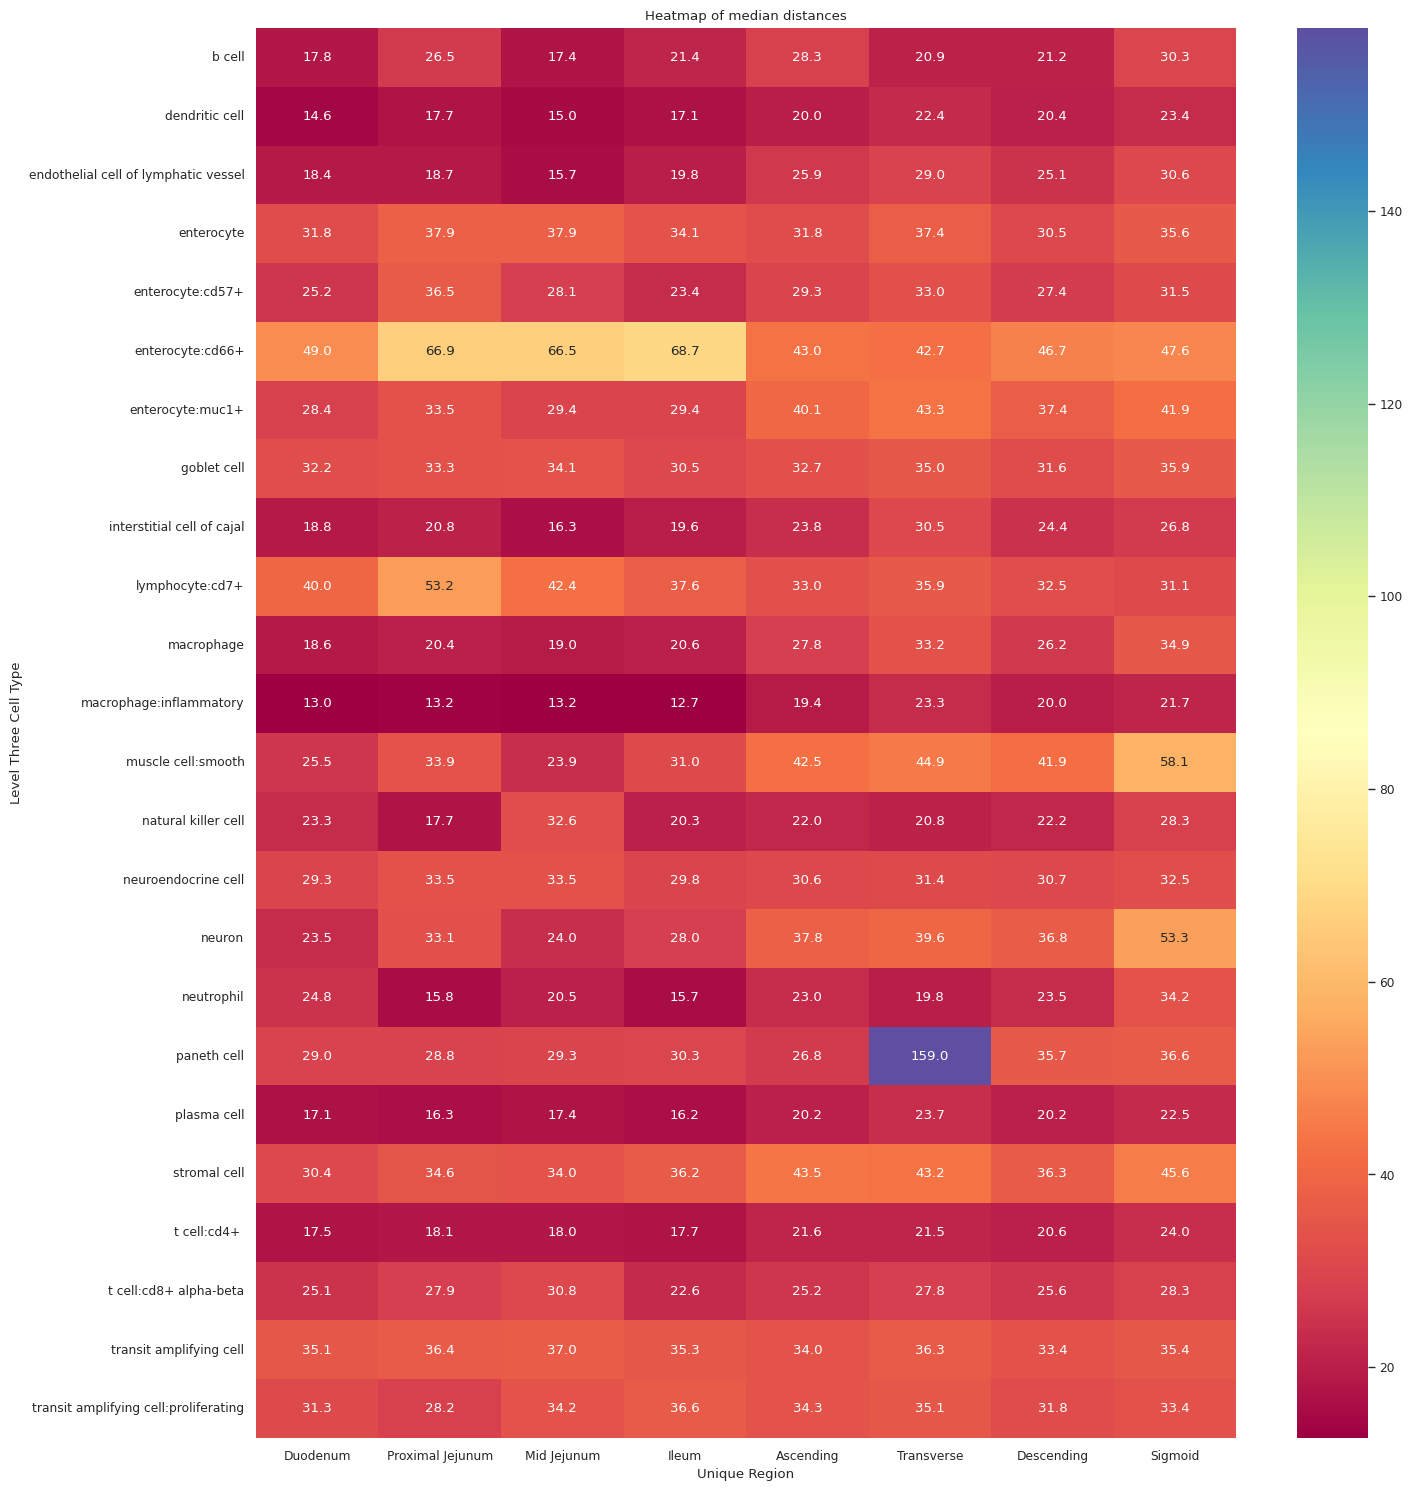

In [148]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

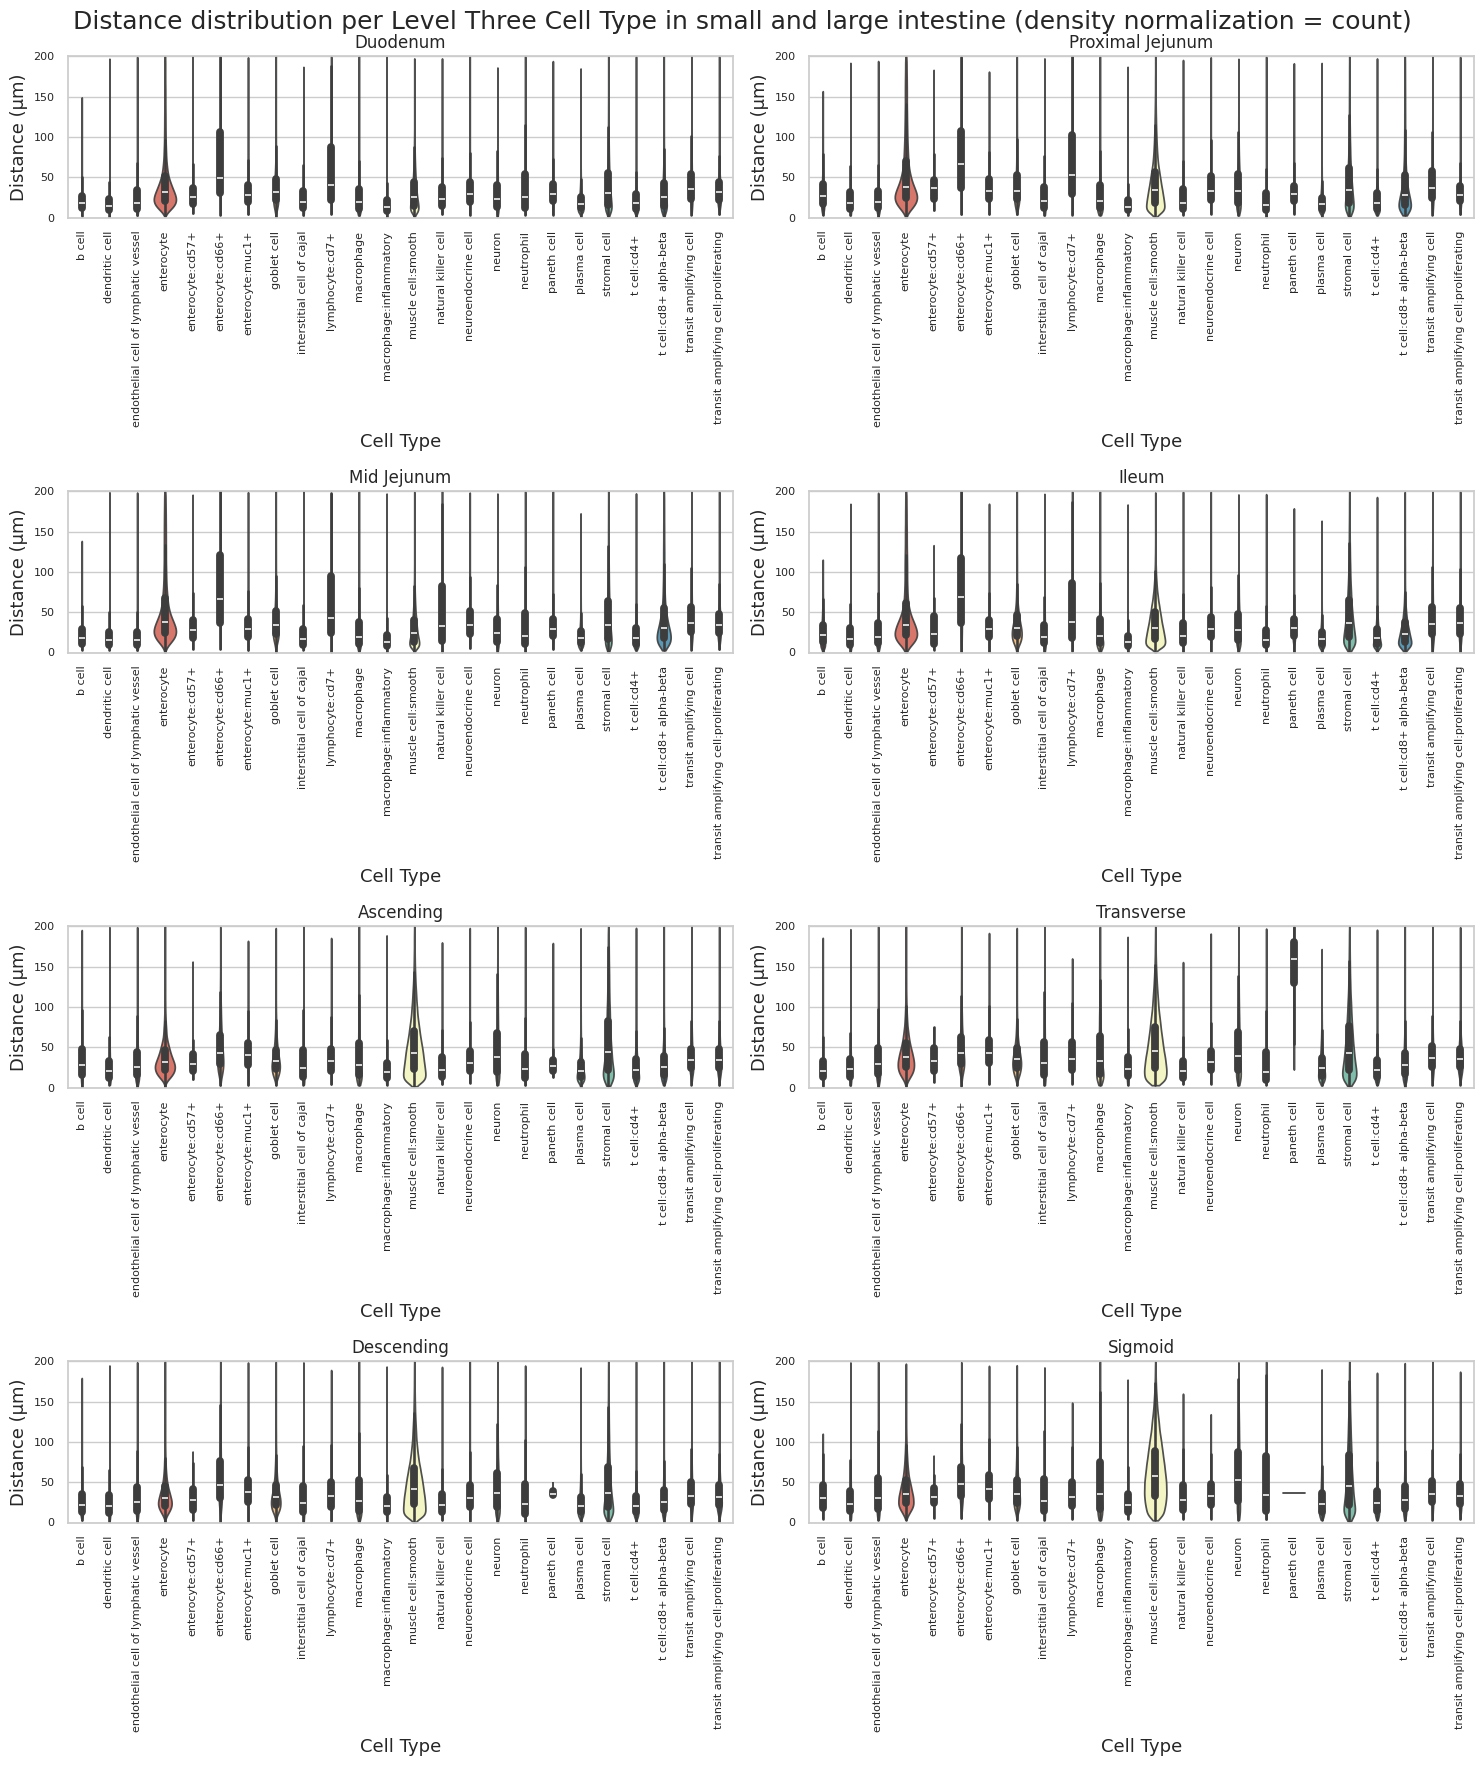

In [149]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count"